In [12]:
# ===================================================================
# IMPORTS
# ===================================================================
# Reload functions after changes
import importlib
import functions
importlib.reload(functions)
from functions import *


Libraries imported successfully
pymrio version: 0.5.4
Base path: C:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit
EXIOBASE data path: C:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit\Exiobase3_ixi_latest
Results will be saved to: C:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit\Results
Years for time series: 1995-2022
Loading population data from: C:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit\code\producerappraoch\clean code\exiobase3_population_2022_official.csv
Population data shape: (49, 3)
Columns: ['EXIOBASE3_Code', 'Population_2022', 'Source']

First 5 rows:
  EXIOBASE3_Code  Population_2022             Source
0             AT       9041851.00  World Bank (2022)
1             BE      11680210.00  World Bank (2022)
2             BG       6643324.00  World Bank (2022)
3             CY       1331370.00  World Bank (2022)
4             CZ      10672118.00  World Bank (2022)
Defined 20 emission categories
Defined 9 total value-added components
  - 2 tax components
 

In [13]:

# ===================================================================
# LOAD DATA
# ===================================================================

# Load EXIOBASE for single year
ixi_data = load_exiobase_year(SINGLE_YEAR)



Loading EXIOBASE data for year 2019...
✓ Year 2019 loaded successfully
  Regions: 49
  Sectors: 163


In [14]:
# ===================================================================
# SECTOR MAPPING
# ===================================================================

# Get all sectors from EXIOBASE
all_sectors = ixi_data.get_sectors()
print(f"Total sectors in EXIOBASE: {len(all_sectors)}")

# Create DataFrame with sector mapping
df_sectors = pd.DataFrame({'sector': all_sectors})
df_sectors['category'] = df_sectors['sector'].apply(category_of)
df_sectors['colour'] = df_sectors['sector'].apply(colour_of)

print("\nSector distribution:")
print(df_sectors['category'].value_counts())

# Create analysis-specific sector lists
fossil_sectors = get_sectors_by_categories(["Coal", "Oil", "Gas"])
service_sectors = get_sectors_by_categories(["Services"])
Manufacturing_sectors = get_sectors_by_categories(["Manufacturing (Food & Beverages)", "Manufacturing (Textiles, Leather & Wood)", "Manufacturing (Machinery & Equipment)"])

print(f"\nFossil fuel sectors: {len(fossil_sectors)}")

print(f"Service sectors: {len(service_sectors)}")

print(f"Manufacturing sectors: {len(Manufacturing_sectors)}")

Total sectors in EXIOBASE: 163

Sector distribution:
Waste & Recycling                           35
Services                                    19
Agriculture                                 17
Metals                                      15
Manufacturing (Food & Beverages)            12
Non-metallic Minerals                        9
Manufacturing (Machinery & Equipment)        8
Chemicals & Plastics                         7
Energy & Utilities Infrastructure            7
Renewables                                   7
Transport                                    7
Gas                                          5
Manufacturing (Textiles, Leather & Wood)     5
Oil                                          4
Coal                                         3
Construction & Trade                         3
Name: category, dtype: int64

Fossil fuel sectors: 12
Service sectors: 23
Manufacturing sectors: 25


In [15]:
# ===================================================================
# CALCULATE CLEAN VA COEFFICIENTS
# ===================================================================

# All components
v_clean_all, v_raw_all = calculate_clean_va_coefficients(
    ixi_data, VALUE_ADDED_COMPONENTS
)

# Profit only
v_clean_profit, v_raw_profit = calculate_clean_va_coefficients(
    ixi_data, PROFIT_COMPONENTS
)

# Without taxes
components_no_tax = [c for c in VALUE_ADDED_COMPONENTS if c not in TAX_COMPONENTS]
v_clean_no_tax, v_raw_no_tax = calculate_clean_va_coefficients(
    ixi_data, components_no_tax
)

# ===================================================================
# RUN RESPONSIBILITY CALCULATIONS
# ===================================================================

print("\n" + "="*70)
print("CALCULATING ALL RESPONSIBILITY METHODS")
print("="*70)

# Producer responsibility
producer_emissions, missing = calculate_producer_responsibility(
    ixi_data, EMISSION_CATEGORIES
)

# Consumer responsibility
consumer_by_country, consumer_details = calculate_consumer_responsibility(
    ixi_data, producer_emissions
)

# VABR - all components
vabr_all, vabr_all_details, consumer_baseline = calculate_vabr(
    ixi_data, producer_emissions, v_clean_all
)

# VABR - profit only
vabr_profit, vabr_profit_details, _ = calculate_vabr(
    ixi_data, producer_emissions, v_clean_profit
)

# VABR - no taxes
vabr_no_tax, vabr_no_tax_details, _ = calculate_vabr(
    ixi_data, producer_emissions, v_clean_no_tax
)
## Technology-adjusted VABR calculations
# # 1. World average emission intensity benchmark
vabr_world, sectors_world, consumer_world = calculate_vabr_tech_adjusted(
    ixi_data=ixi_data,
    producer_emissions=producer_emissions,
    v_clean=v_clean_all,  # Use same VA as standard VABR
    benchmark_mode="world_avg",
    conserve_global=True
)

# 2. Best-in-class emission intensity benchmark (SENSITIVITY - Technology transfer responsibility)
vabr_best, sectors_best, consumer_best = calculate_vabr_tech_adjusted(
    ixi_data=ixi_data,
    producer_emissions=producer_emissions,
    v_clean=v_clean_all,
    benchmark_mode="best",
    conserve_global=True
)

# 3. Worst-in-class emission intensity benchmark (SENSITIVITY - Maximum consumption penalty)
vabr_worst, sectors_worst, consumer_worst = calculate_vabr_tech_adjusted(
    ixi_data=ixi_data,
    producer_emissions=producer_emissions,
    v_clean=v_clean_all,
    benchmark_mode="worst",
    conserve_global=True
)

## Bottom-up supply drived responsibility calculation
# (producer-centric profit-based responsibility calculation)
pcpr_totals, pcpr_details = calculate_pcpr(
    ixi_data, 
    producer_emissions, 
    profit_components=PROFIT_COMPONENTS,
    method='inverse'
)

print("\n" + "="*70)
print("ALL CALCULATIONS COMPLETE")
print("="*70)


Calculating VA coefficients using 9 components...
  Set 0 negative VA values to 0
  Capped 37 coefficients > 1
  BEFORE cleaning: Min=0.0000, Max=1.7726
  AFTER cleaning:  Min=0.0000, Max=1.0000
Calculating VA coefficients using 4 components...
  Set 0 negative VA values to 0
  Capped 15 coefficients > 1
  BEFORE cleaning: Min=0.0000, Max=36.3956
  AFTER cleaning:  Min=0.0000, Max=1.0000
Calculating VA coefficients using 7 components...
  Set 0 negative VA values to 0
  Capped 59 coefficients > 1
  BEFORE cleaning: Min=0.0000, Max=37.3111
  AFTER cleaning:  Min=0.0000, Max=1.0000

CALCULATING ALL RESPONSIBILITY METHODS
Total producer emissions: 44.715 Gt CO2-eq
Total consumer emissions: 44.712 Gt CO2-eq

=== VABR CALCULATION ===
Return allocation details: False
Total consumer emissions: 44.712 Gt
Total VABR: 44.712 Gt, Error: 0.0000%

=== VABR CALCULATION ===
Return allocation details: False
Total consumer emissions: 44.712 Gt
Total VABR: 44.712 Gt, Error: 0.0000%

=== VABR CALCULATION


=== Aggregating producer emissions by country ===
Total producer emissions: 44.715 Gt

=== Calculating PCPR with all VA components ===

=== PRODUCER-CENTRIC PROFIT-BASED RESPONSIBILITY (INVERSE) ===
Sectors: 7987, Regions: 49
Total emissions: 44.715 Gt CO2-eq
Floored sectors: 4479 (56.1%)
S row sums: mean=0.525, max=1.000
Total profit VA: 0.1 B€
Profit coefficients: mean=0.213
Computing D = (I - S)^(-1)...
  Condition number: 1.25e+01
FD flows: direct=0.200, total=0.515 (ratio: 2.57x)
Per-producer allocation...
  Producers processed: 6947
  Zero profit capture: 470
Conservation: 44.7154 Gt (error: 0.000000%)

Top 5 countries:
  CN: 12.914 Gt (1.00x)
  US: 5.292 Gt (1.04x)
  IN: 3.392 Gt (0.98x)
  WA: 3.317 Gt (0.94x)
  WM: 2.690 Gt (0.88x)

ANALYSIS 1: Top Emitters - Comparison of All Methods (2019)

Comparison DataFrame shape: (49, 6)
Methods: ['Producer', 'Consumer', 'VABR (All VA)', 'VABR (Profit)', 'PCPR (All VA)', 'PCPR (Profit)']

TOP 10 EMITTERS BY METHOD (Gt CO2-eq)

PRODUCER:

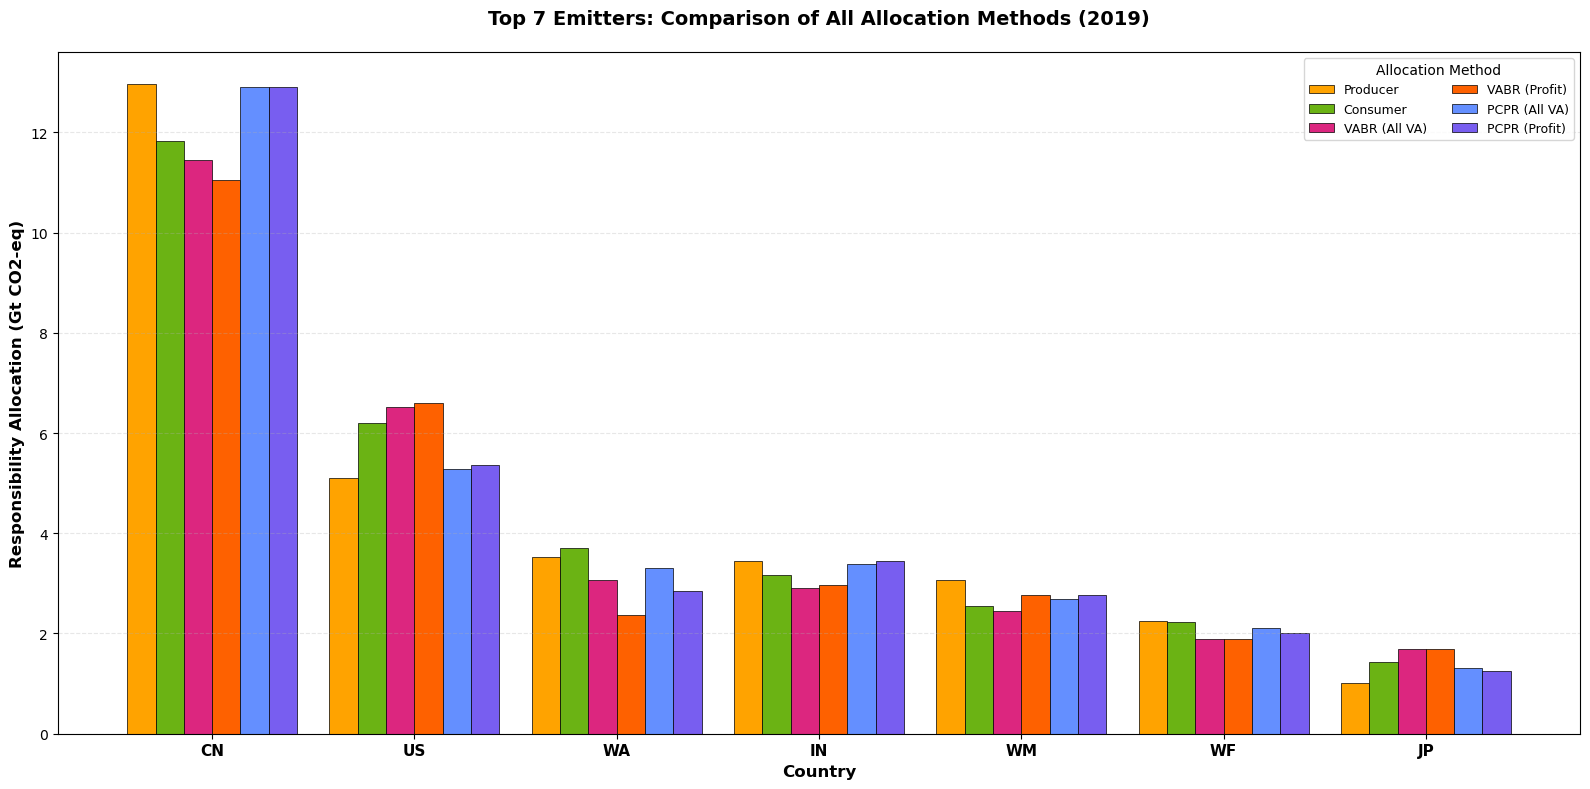


✓ Top 7 emitters bar chart created (6 methods)

### Summary Statistics ###
Top 7 represent:
  Producer            : 31.34 Gt (70.1% of global)
  Consumer            : 31.10 Gt (69.5% of global)
  VABR (All VA)       : 29.97 Gt (67.0% of global)
  VABR (Profit)       : 29.29 Gt (65.5% of global)
  PCPR (All VA)       : 31.03 Gt (69.4% of global)
  PCPR (Profit)       : 30.58 Gt (68.4% of global)

### Detailed Method Comparison (Top 7 Countries) ###

CN:
  Producer:        12.96 Gt (100%)
  Consumer:        11.82 Gt ( 91.2%)
  VABR (All VA):   11.46 Gt ( 88.4%)
  VABR (Profit):   11.04 Gt ( 85.2%)
  PCPR (All VA):   12.91 Gt ( 99.6%)
  PCPR (Profit):   12.91 Gt ( 99.6%)
  → Closest to Producer: PCPR (All VA) (diff: 0.05 Gt)

US:
  Producer:         5.10 Gt (100%)
  Consumer:         6.21 Gt (121.7%)
  VABR (All VA):    6.52 Gt (127.9%)
  VABR (Profit):    6.59 Gt (129.2%)
  PCPR (All VA):    5.29 Gt (103.8%)
  PCPR (Profit):    5.37 Gt (105.3%)
  → Closest to Producer: PCPR (All VA) (di

In [16]:
# ===================================================================
# AGGREGATE PRODUCER EMISSIONS BY COUNTRY
# ===================================================================
print("\n=== Aggregating producer emissions by country ===")

regions = ixi_data.get_regions()
producer_by_country = {}

for region in regions:
    region_mask = ixi_data.x.index.get_level_values(0) == region
    region_indices = np.where(region_mask)[0]
    producer_by_country[region] = producer_emissions[region_indices].sum()

producer_series = pd.Series(producer_by_country)
print(f"Total producer emissions: {producer_series.sum()/1e9:.3f} Gt")

# ===================================================================
# CALCULATE MISSING PCPR VARIANT (with all VA)
# ===================================================================
print("\n=== Calculating PCPR with all VA components ===")

pcpr_all_totals, pcpr_all_details = calculate_pcpr(
    ixi_data, 
    producer_emissions, 
    profit_components=VALUE_ADDED_COMPONENTS,  # All VA!
    method='inverse'
)

# ===================================================================
# ANALYSIS: TOP EMITTERS - ALL ALLOCATION METHODS
# ===================================================================

print("\n" + "="*70)
print(f"ANALYSIS 1: Top Emitters - Comparison of All Methods ({SINGLE_YEAR})")
print("="*70)

# Create comparison DataFrame with ALL 6 methods
comparison_df = pd.DataFrame({
    'Producer': producer_series / 1e9,
    'Consumer': consumer_by_country / 1e9,
    'VABR (All VA)': vabr_all / 1e9,
    'VABR (Profit)': vabr_profit / 1e9,
    'PCPR (All VA)': pcpr_all_totals / 1e9,
    'PCPR (Profit)': pcpr_totals / 1e9
})

print(f"\nComparison DataFrame shape: {comparison_df.shape}")
print(f"Methods: {list(comparison_df.columns)}")

# ===================================================================
# PRINT TOP 10 FOR EACH METHOD
# ===================================================================

print("\n" + "="*70)
print("TOP 10 EMITTERS BY METHOD (Gt CO2-eq)")
print("="*70)

for method in comparison_df.columns:
    print(f"\n{method.upper()}:")
    top10 = comparison_df[method].nlargest(10)
    for i, (country, emissions) in enumerate(top10.items(), 1):
        print(f"{i:2d}. {country}: {emissions:6.2f} Gt")

# ===================================================================
# BAR PLOT: TOP 7 COUNTRIES
# ===================================================================

# Select top 7 countries by VABR (All VA)
top7_countries = comparison_df['VABR (All VA)'].nlargest(7).index.tolist()
plot_data = comparison_df.loc[top7_countries]

print(f"\nTop 7 countries for bar plot: {top7_countries}")

# Create plot
fig, ax = plt.subplots(figsize=(16, 8))

n_methods = len(plot_data.columns)
x = np.arange(len(top7_countries))
width = 0.14

# Colors for all 6 methods (UPDATED NAMES)
colors = {
    'Producer': '#ffa300',
    'Consumer': '#6bb314',
    'VABR (All VA)': '#dc267f',
    'VABR (Profit)': '#fe6100',
    'PCPR (All VA)': '#648fff',      # Changed from Bottom-Up
    'PCPR (Profit)': '#785ef0'       # Changed from Bottom-Up
}

for i, method in enumerate(plot_data.columns):
    ax.bar(
        x + i * width - (n_methods * width / 2) + (width / 2),
        plot_data[method].values,
        width,
        label=method,
        color=colors[method],
        edgecolor='black',
        linewidth=0.5
    )

ax.set_title(f'Top 7 Emitters: Comparison of All Allocation Methods ({SINGLE_YEAR})',
             fontsize=14, fontweight='bold', pad=20)
ax.set_ylabel('Responsibility Allocation (Gt CO2-eq)', fontsize=12, fontweight='bold')
ax.set_xlabel('Country', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(top7_countries, fontsize=11, fontweight='bold')
ax.legend(title="Allocation Method", fontsize=9, title_fontsize=10, 
          loc='upper right', ncol=2)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("\n✓ Top 7 emitters bar chart created (6 methods)")

# ===================================================================
# SUMMARY STATISTICS
# ===================================================================

print("\n### Summary Statistics ###")
print(f"Top 7 represent:")
for method in comparison_df.columns:
    top7_sum = plot_data[method].sum()
    total = comparison_df[method].sum()
    percentage = (top7_sum / total) * 100
    print(f"  {method:20s}: {top7_sum:5.2f} Gt ({percentage:4.1f}% of global)")

# ===================================================================
# METHOD COMPARISON BY COUNTRY
# ===================================================================

print("\n### Detailed Method Comparison (Top 7 Countries) ###")

for country in top7_countries:
    producer = comparison_df.loc[country, 'Producer']
    consumer = comparison_df.loc[country, 'Consumer']
    vabr_all = comparison_df.loc[country, 'VABR (All VA)']
    vabr_profit = comparison_df.loc[country, 'VABR (Profit)']
    pcpr_all = comparison_df.loc[country, 'PCPR (All VA)']
    pcpr_profit = comparison_df.loc[country, 'PCPR (Profit)']
    
    print(f"\n{country}:")
    print(f"  Producer:        {producer:5.2f} Gt (100%)")
    print(f"  Consumer:        {consumer:5.2f} Gt ({consumer/producer*100:5.1f}%)")
    print(f"  VABR (All VA):   {vabr_all:5.2f} Gt ({vabr_all/producer*100:5.1f}%)")
    print(f"  VABR (Profit):   {vabr_profit:5.2f} Gt ({vabr_profit/producer*100:5.1f}%)")
    print(f"  PCPR (All VA):   {pcpr_all:5.2f} Gt ({pcpr_all/producer*100:5.1f}%)")
    print(f"  PCPR (Profit):   {pcpr_profit:5.2f} Gt ({pcpr_profit/producer*100:5.1f}%)")
    
    # Find which method is closest to Producer
    methods_dict = {
        'Consumer': consumer,
        'VABR (All VA)': vabr_all,
        'VABR (Profit)': vabr_profit,
        'PCPR (All VA)': pcpr_all,
        'PCPR (Profit)': pcpr_profit
    }
    
    closest = min(methods_dict.items(), key=lambda x: abs(x[1] - producer))
    print(f"  → Closest to Producer: {closest[0]} (diff: {abs(closest[1] - producer):.2f} Gt)")

# ===================================================================
# CORRELATION ANALYSIS
# ===================================================================

print("\n### Correlation Matrix (All Countries) ###")
corr_matrix = comparison_df.corr().round(3)
print(corr_matrix)

# ===================================================================
# KEY PATTERNS
# ===================================================================

print("\n### Key Patterns Across Methods ###")

# Compare VABR vs PCPR
print("\nVABR (All VA) vs PCPR (All VA):")
print("Countries where PCPR allocates LESS than VABR:")
diff_vabr_pcpr = comparison_df['VABR (All VA)'] - comparison_df['PCPR (All VA)']
biggest_diff = diff_vabr_pcpr.nlargest(10)
for country, diff in biggest_diff.items():
    vabr_val = comparison_df.loc[country, 'VABR (All VA)']
    pcpr_val = comparison_df.loc[country, 'PCPR (All VA)']
    print(f"  {country}: VABR {vabr_val:.2f} → PCPR {pcpr_val:.2f} (diff: {diff:.2f} Gt)")

print("\nCountries where PCPR allocates MORE than VABR:")
smallest_diff = diff_vabr_pcpr.nsmallest(10)
for country, diff in smallest_diff.items():
    vabr_val = comparison_df.loc[country, 'VABR (All VA)']
    pcpr_val = comparison_df.loc[country, 'PCPR (All VA)']
    print(f"  {country}: VABR {vabr_val:.2f} → PCPR {pcpr_val:.2f} (diff: {diff:+.2f} Gt)")

# Effect of Profit-only
print("\n### Effect of Profit-Only Specification ###")

print("\nVABR: All VA vs Profit")
vabr_change = comparison_df['VABR (Profit)'] - comparison_df['VABR (All VA)']
print(f"Average change: {vabr_change.mean():+.3f} Gt")
print(f"Countries most affected (top 5):")
for country in vabr_change.abs().nlargest(5).index:
    change = vabr_change[country]
    print(f"  {country}: {change:+.2f} Gt")

print("\nPCPR: All VA vs Profit")
pcpr_change = comparison_df['PCPR (Profit)'] - comparison_df['PCPR (All VA)']
print(f"Average change: {pcpr_change.mean():+.3f} Gt")
print(f"Countries most affected (top 5):")
for country in pcpr_change.abs().nlargest(5).index:
    change = pcpr_change[country]
    print(f"  {country}: {change:+.2f} Gt")

ANALYSIS


SLOPE CHART: Country Rankings Across Methods

Countries shown: 18
Methods: ['Producer', 'Consumer', 'VABR (All VA)', 'VABR (Profit)', 'PCPR (All VA)', 'PCPR (Profit)']


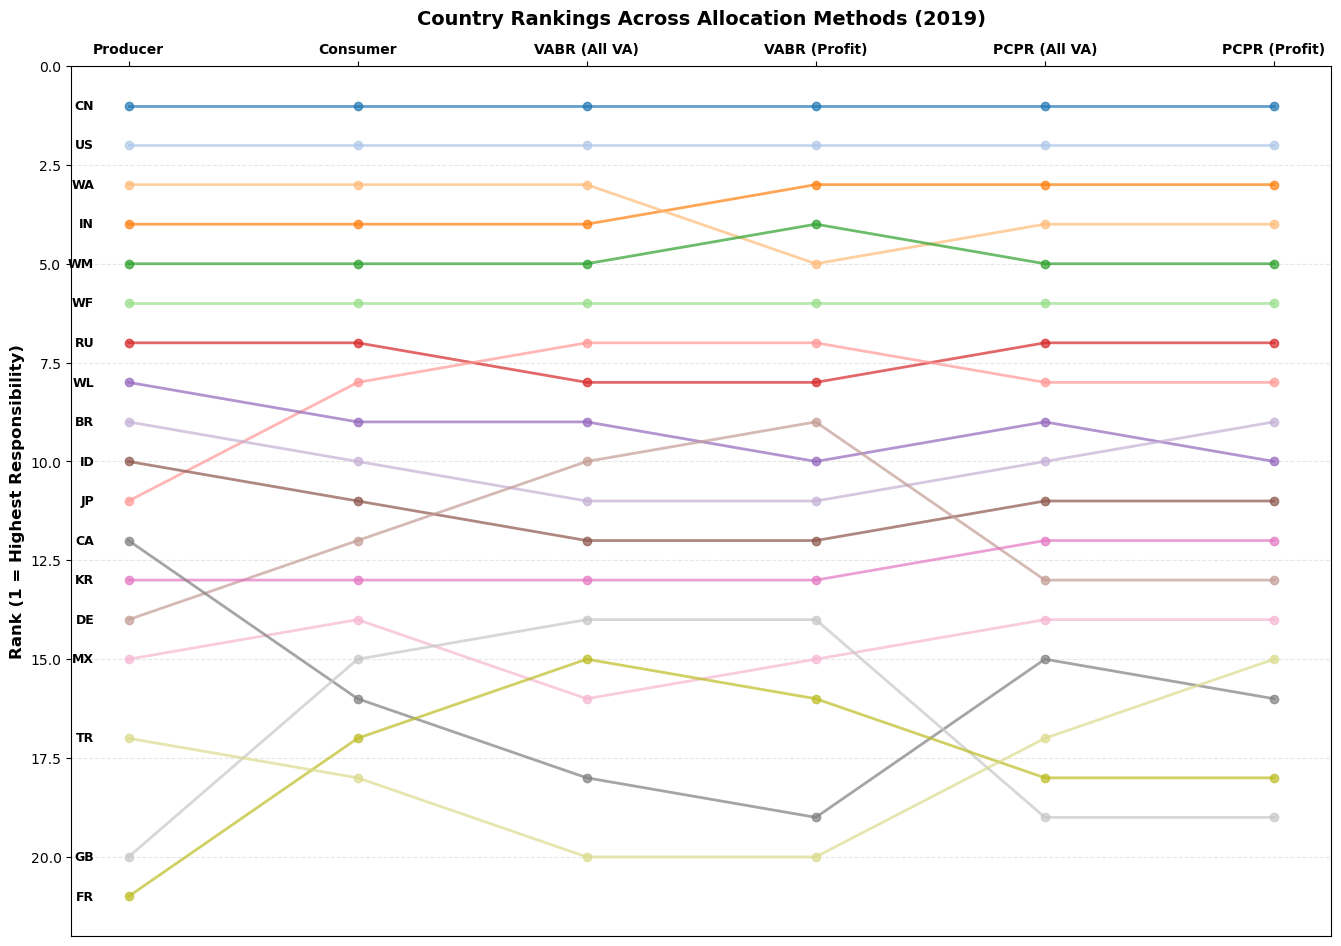


✓ Slope chart created

### Biggest Rank Changes ###

Producer → Consumer:
  Biggest rank improvements:
    GB: #20 → #15 (-5)
    FR: #21 → #17 (-4)
    JP: #11 → #8 (-3)
  Biggest rank declines:
    CA: #12 → #16 (+4)
    WL: #8 → #9 (+1)
    BR: #9 → #10 (+1)

Consumer → VABR (All VA):
  Biggest rank improvements:
    DE: #12 → #10 (-2)
    FR: #17 → #15 (-2)
    JP: #8 → #7 (-1)
  Biggest rank declines:
    MX: #14 → #16 (+2)
    CA: #16 → #18 (+2)
    TR: #18 → #20 (+2)

VABR (All VA) → VABR (Profit):
  Biggest rank improvements:
    IN: #4 → #3 (-1)
    WM: #5 → #4 (-1)
    DE: #10 → #9 (-1)
  Biggest rank declines:
    WA: #3 → #5 (+2)
    WL: #9 → #10 (+1)
    CA: #18 → #19 (+1)

VABR (Profit) → PCPR (All VA):
  Biggest rank improvements:
    CA: #19 → #15 (-4)
    TR: #20 → #17 (-3)
    WA: #5 → #4 (-1)
  Biggest rank declines:
    GB: #14 → #19 (+5)
    DE: #9 → #13 (+4)
    FR: #16 → #18 (+2)

PCPR (All VA) → PCPR (Profit):
  Biggest rank improvements:
    TR: #17 → #15 (-2)

In [6]:
# ===================================================================
# SLOPE CHART: RANK CHANGES ACROSS ALL ALLOCATION METHODS
# ===================================================================

print("\n" + "="*70)
print("SLOPE CHART: Country Rankings Across Methods")
print("="*70)

# Compute ranks (1 = highest emitter)
ranks = comparison_df.rank(ascending=False, method='min')

# Keep top 15 countries (appear in top 15 in any method)
top_countries = pd.Index(
    np.unique(
        np.concatenate([ranks[col].nsmallest(15).index for col in ranks.columns])
    )
)

# Filter to those countries only
ranks_filtered = ranks.loc[top_countries]

# Sort by average rank for better visualization
avg_rank = ranks_filtered.mean(axis=1).sort_values()
ranks_filtered = ranks_filtered.loc[avg_rank.index]

print(f"\nCountries shown: {len(ranks_filtered)}")
print(f"Methods: {list(ranks_filtered.columns)}")

# Define x positions
approaches = ranks_filtered.columns.tolist()
x = np.arange(len(approaches))

# Plot
fig, ax = plt.subplots(figsize=(14, 10))

# Color palette
colors = plt.cm.tab20.colors

for i, country in enumerate(ranks_filtered.index):
    # Plot line
    ax.plot(x, ranks_filtered.loc[country], 
            marker='o', 
            color=colors[i % len(colors)],
            linewidth=2,
            markersize=6,
            alpha=0.7)
    
    # Add country label on the LEFT (at first method)
    ax.text(x[0] - 0.15, ranks_filtered.loc[country, approaches[0]],
            country, 
            ha='right',
            va='center', 
            fontsize=9,
            fontweight='bold')

# Set x-axis with method names on TOP
ax.set_xticks(x)
ax.set_xticklabels([])  # Remove bottom labels
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.set_xticks(x)
ax.set_xticklabels(approaches, fontsize=10, fontweight='bold', rotation=0, ha='center')

# Y-axis
ax.set_ylabel("Rank (1 = Highest Responsibility)", fontsize=12, fontweight='bold')
ax.invert_yaxis()  # Rank 1 at top

# Title below x-axis labels
ax.set_title(f"Country Rankings Across Allocation Methods ({SINGLE_YEAR})", 
             fontsize=14, fontweight='bold', pad=30)

# Grid
ax.grid(alpha=0.3, linestyle='--', axis='y')

# Adjust layout to prevent label cutoff
plt.subplots_adjust(left=0.08, right=0.98, top=0.92, bottom=0.05)

plt.show()

print("\n✓ Slope chart created")

# ===================================================================
# ANALYZE RANK CHANGES
# ===================================================================

print("\n### Biggest Rank Changes ###")

for method_idx in range(1, len(approaches)):
    prev_method = approaches[method_idx - 1]
    curr_method = approaches[method_idx]
    
    rank_change = ranks_filtered[curr_method] - ranks_filtered[prev_method]
    
    print(f"\n{prev_method} → {curr_method}:")
    
    # Biggest improvements (rank goes DOWN = better)
    improvers = rank_change.nsmallest(3)
    if len(improvers) > 0:
        print("  Biggest rank improvements:")
        for country, change in improvers.items():
            old_rank = ranks_filtered.loc[country, prev_method]
            new_rank = ranks_filtered.loc[country, curr_method]
            print(f"    {country}: #{int(old_rank)} → #{int(new_rank)} ({int(change):+d})")
    
    # Biggest declines (rank goes UP = worse)
    decliners = rank_change.nlargest(3)
    if len(decliners) > 0:
        print("  Biggest rank declines:")
        for country, change in decliners.items():
            old_rank = ranks_filtered.loc[country, prev_method]
            new_rank = ranks_filtered.loc[country, curr_method]
            print(f"    {country}: #{int(old_rank)} → #{int(new_rank)} ({int(change):+d})")

# ===================================================================
# KEY INSIGHTS
# ===================================================================

print("\n### Key Insights ###")

# Most stable countries (low variance in ranks)
rank_variance = ranks_filtered.var(axis=1).sort_values()
print("\nMost stable rankings (consistent across methods):")
for country in rank_variance.head(5).index:
    mean_rank = ranks_filtered.loc[country].mean()
    std_rank = ranks_filtered.loc[country].std()
    print(f"  {country}: avg rank {mean_rank:.1f} (±{std_rank:.1f})")

# Most volatile countries (high variance in ranks)
print("\nMost volatile rankings (vary greatly by method):")
for country in rank_variance.tail(5).index:
    mean_rank = ranks_filtered.loc[country].mean()
    std_rank = ranks_filtered.loc[country].std()
    min_rank = ranks_filtered.loc[country].min()
    max_rank = ranks_filtered.loc[country].max()
    print(f"  {country}: avg {mean_rank:.1f} (±{std_rank:.1f}), range #{int(min_rank)}-#{int(max_rank)}")

# ===================================================================
# COMPARE PRODUCER VS PCPR
# ===================================================================

print("\n### Producer vs PCPR Comparison ###")
producer_ranks = ranks_filtered['Producer']
pcpr_all_ranks = ranks_filtered['PCPR (All VA)']  # ✅ Fixed name
rank_diff = pcpr_all_ranks - producer_ranks

print("\nCountries that rank BETTER under PCPR:")
better = rank_diff[rank_diff < 0].sort_values()
for country, diff in better.head(5).items():
    print(f"  {country}: #{int(producer_ranks[country])} → #{int(pcpr_all_ranks[country])} ({int(diff):+d})")

print("\nCountries that rank WORSE under PCPR:")
worse = rank_diff[rank_diff > 0].sort_values(ascending=False)
for country, diff in worse.head(5).items():
    print(f"  {country}: #{int(producer_ranks[country])} → #{int(pcpr_all_ranks[country])} ({int(diff):+d})")

# ===================================================================
# ADDITIONAL INSIGHT: VABR VS PCPR
# ===================================================================

print("\n### VABR vs PCPR Comparison ###")
vabr_ranks = ranks_filtered['VABR (All VA)']
pcpr_ranks = ranks_filtered['PCPR (All VA)']
vabr_pcpr_diff = pcpr_ranks - vabr_ranks

print("\nCountries that rank BETTER under PCPR than VABR:")
better_pcpr = vabr_pcpr_diff[vabr_pcpr_diff < 0].sort_values()
for country, diff in better_pcpr.head(5).items():
    print(f"  {country}: VABR #{int(vabr_ranks[country])} → PCPR #{int(pcpr_ranks[country])} ({int(diff):+d})")

print("\nCountries that rank WORSE under PCPR than VABR:")
worse_pcpr = vabr_pcpr_diff[vabr_pcpr_diff > 0].sort_values(ascending=False)
for country, diff in worse_pcpr.head(5).items():
    print(f"  {country}: VABR #{int(vabr_ranks[country])} → PCPR #{int(pcpr_ranks[country])} ({int(diff):+d})")


SLOPE CHART: Country Rankings Across Methods (ALL REGIONS)

Total countries/regions: 49
Methods: ['Producer', 'Consumer', 'VABR (All VA)', 'VABR (Profit)', 'PCPR (All VA)', 'PCPR (Profit)']


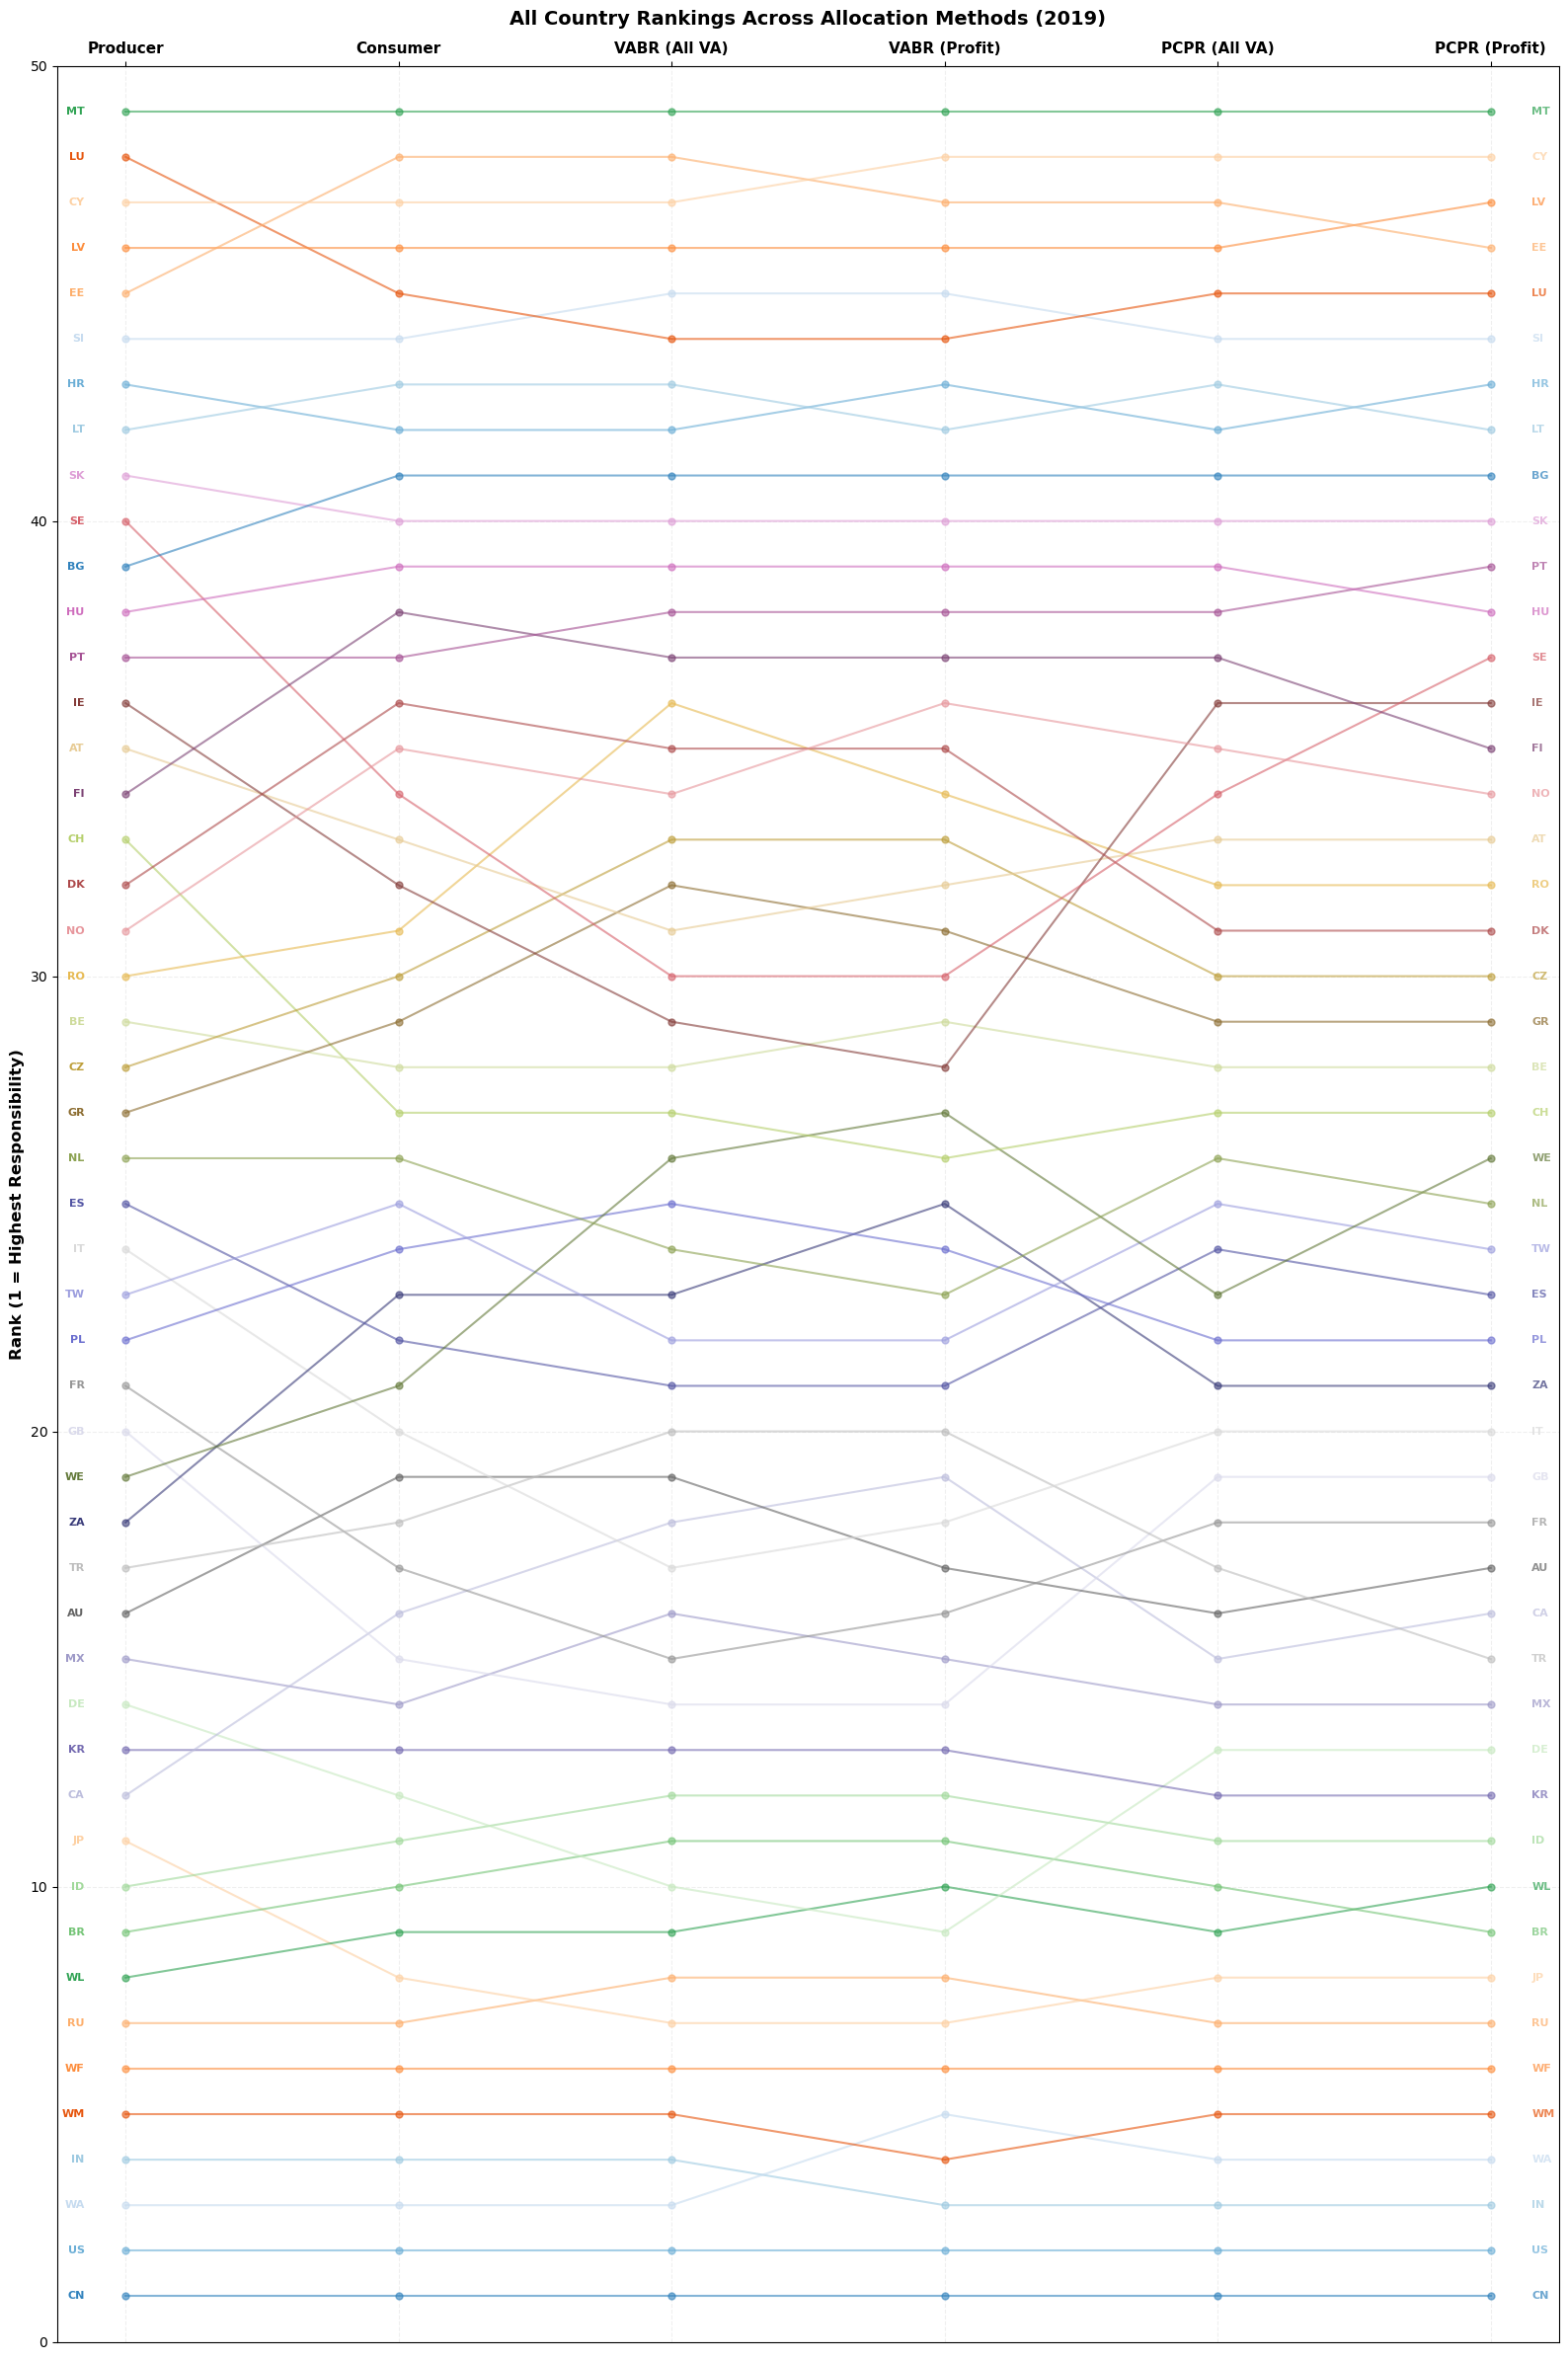


✓ Slope chart created (all regions)

### Biggest Rank Changes (All Regions) ###

Producer → Consumer:
  Biggest rank improvements:
    CH: #33 → #27 (-6)
    SE: #40 → #34 (-6)
    GB: #20 → #15 (-5)
    FR: #21 → #17 (-4)
    IT: #24 → #20 (-4)
  Biggest rank declines:
    ZA: #18 → #23 (+5)
    CA: #12 → #16 (+4)
    DK: #32 → #36 (+4)
    NO: #31 → #35 (+4)
    FI: #34 → #38 (+4)

Consumer → VABR (All VA):
  Biggest rank improvements:
    SE: #34 → #30 (-4)
    IT: #20 → #17 (-3)
    TW: #25 → #22 (-3)
    IE: #32 → #29 (-3)
    DE: #12 → #10 (-2)
  Biggest rank declines:
    WE: #21 → #26 (+5)
    RO: #31 → #36 (+5)
    GR: #29 → #32 (+3)
    CZ: #30 → #33 (+3)
    MX: #14 → #16 (+2)

VABR (All VA) → VABR (Profit):
  Biggest rank improvements:
    AU: #19 → #17 (-2)
    RO: #36 → #34 (-2)
    IN: #4 → #3 (-1)
    WM: #5 → #4 (-1)
    DE: #10 → #9 (-1)
  Biggest rank declines:
    WA: #3 → #5 (+2)
    ZA: #23 → #25 (+2)
    NO: #34 → #36 (+2)
    WL: #9 → #10 (+1)
    CA: #18 → #19

In [7]:
# ===================================================================
# SLOPE CHART: RANK CHANGES ACROSS ALL ALLOCATION METHODS
# ===================================================================

print("\n" + "="*70)
print("SLOPE CHART: Country Rankings Across Methods (ALL REGIONS)")
print("="*70)

# Compute ranks (1 = highest emitter)
ranks = comparison_df.rank(ascending=False, method='min')

print(f"\nTotal countries/regions: {len(ranks)}")
print(f"Methods: {list(ranks.columns)}")

# Sort by average rank for better visualization
avg_rank = ranks.mean(axis=1).sort_values()
ranks_sorted = ranks.loc[avg_rank.index]

# Define x positions
approaches = ranks_sorted.columns.tolist()
x = np.arange(len(approaches))

# Plot - MUCH BIGGER for all countries
fig, ax = plt.subplots(figsize=(16, 24))  # Tall figure for all countries

# Color palette - cycle through colors
colors = plt.cm.tab20c.colors + plt.cm.tab20b.colors  # 40 colors

for i, country in enumerate(ranks_sorted.index):
    # Plot line
    ax.plot(x, ranks_sorted.loc[country], 
            marker='o', 
            color=colors[i % len(colors)],
            linewidth=1.5,
            markersize=5,
            alpha=0.6)
    
    # Add country label on the LEFT (at first method)
    ax.text(x[0] - 0.15, ranks_sorted.loc[country, approaches[0]],
            country, 
            ha='right',
            va='center', 
            fontsize=8,
            fontweight='bold',
            color=colors[i % len(colors)])
    
    # OPTIONAL: Also add label on the RIGHT (at last method) for easier reading
    ax.text(x[-1] + 0.15, ranks_sorted.loc[country, approaches[-1]],
            country, 
            ha='left',
            va='center', 
            fontsize=8,
            fontweight='bold',
            color=colors[i % len(colors)],
            alpha=0.7)

# Set x-axis with method names on TOP
ax.set_xticks(x)
ax.set_xticklabels([])  # Remove bottom labels
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.set_xticks(x)
ax.set_xticklabels(approaches, fontsize=11, fontweight='bold', rotation=0, ha='center')

# Y-axis
ax.set_ylabel("Rank (1 = Highest Responsibility)", fontsize=12, fontweight='bold')
ax.set_ylim(len(ranks) + 1, 0)  # Rank 1 at top, with some margin
ax.invert_yaxis()

# Title
ax.set_title(f"All Country Rankings Across Allocation Methods ({SINGLE_YEAR})", 
             fontsize=14, fontweight='bold', pad=30)

# Grid
ax.grid(alpha=0.2, linestyle='--', axis='both')

# Adjust layout to prevent label cutoff
plt.subplots_adjust(left=0.12, right=0.88, top=0.95, bottom=0.02)

plt.tight_layout()
plt.show()

print("\n✓ Slope chart created (all regions)")

# ===================================================================
# ANALYZE RANK CHANGES
# ===================================================================

print("\n### Biggest Rank Changes (All Regions) ###")

for method_idx in range(1, len(approaches)):
    prev_method = approaches[method_idx - 1]
    curr_method = approaches[method_idx]
    
    rank_change = ranks_sorted[curr_method] - ranks_sorted[prev_method]
    
    print(f"\n{prev_method} → {curr_method}:")
    
    # Biggest improvements (rank goes DOWN = better)
    improvers = rank_change.nsmallest(5)  # Show top 5
    if len(improvers) > 0:
        print("  Biggest rank improvements:")
        for country, change in improvers.items():
            old_rank = ranks_sorted.loc[country, prev_method]
            new_rank = ranks_sorted.loc[country, curr_method]
            print(f"    {country}: #{int(old_rank)} → #{int(new_rank)} ({int(change):+d})")
    
    # Biggest declines (rank goes UP = worse)
    decliners = rank_change.nlargest(5)
    if len(decliners) > 0:
        print("  Biggest rank declines:")
        for country, change in decliners.items():
            old_rank = ranks_sorted.loc[country, prev_method]
            new_rank = ranks_sorted.loc[country, curr_method]
            print(f"    {country}: #{int(old_rank)} → #{int(new_rank)} ({int(change):+d})")

# ===================================================================
# KEY INSIGHTS
# ===================================================================

print("\n### Key Insights (All Regions) ###")

# Most stable countries (low variance in ranks)
rank_variance = ranks_sorted.var(axis=1).sort_values()
print("\nMost stable rankings (consistent across methods):")
for country in rank_variance.head(10).index:
    mean_rank = ranks_sorted.loc[country].mean()
    std_rank = ranks_sorted.loc[country].std()
    print(f"  {country}: avg rank {mean_rank:.1f} (±{std_rank:.1f})")

# Most volatile countries (high variance in ranks)
print("\nMost volatile rankings (vary greatly by method):")
for country in rank_variance.tail(10).index:
    mean_rank = ranks_sorted.loc[country].mean()
    std_rank = ranks_sorted.loc[country].std()
    min_rank = ranks_sorted.loc[country].min()
    max_rank = ranks_sorted.loc[country].max()
    print(f"  {country}: avg {mean_rank:.1f} (±{std_rank:.1f}), range #{int(min_rank)}-#{int(max_rank)}")

# Compare traditional methods vs PCPR
print("\n### Producer vs PCPR Comparison ###")
producer_ranks = ranks_sorted['Producer']
pcpr_all_ranks = ranks_sorted['PCPR (All VA)']  # ✅ FIXED NAME
rank_diff = pcpr_all_ranks - producer_ranks

print("\nCountries that rank BETTER under PCPR:")
better = rank_diff[rank_diff < 0].sort_values()
for country, diff in better.head(10).items():  # Top 10
    old_emissions = comparison_df.loc[country, 'Producer']
    new_emissions = comparison_df.loc[country, 'PCPR (All VA)']
    print(f"  {country}: #{int(producer_ranks[country])} → #{int(pcpr_all_ranks[country])} "
          f"({int(diff):+d}) | {old_emissions:.2f} → {new_emissions:.2f} Gt")

print("\nCountries that rank WORSE under PCPR:")
worse = rank_diff[rank_diff > 0].sort_values(ascending=False)
for country, diff in worse.head(10).items():  # Top 10
    old_emissions = comparison_df.loc[country, 'Producer']
    new_emissions = comparison_df.loc[country, 'PCPR (All VA)']
    print(f"  {country}: #{int(producer_ranks[country])} → #{int(pcpr_all_ranks[country])} "
          f"({int(diff):+d}) | {old_emissions:.2f} → {new_emissions:.2f} Gt")

# ===================================================================
# ADDITIONAL: Countries with extreme changes
# ===================================================================

print("\n### Extreme Multipliers (PCPR vs Producer) ###")

multipliers = comparison_df['PCPR (All VA)'] / comparison_df['Producer']
multipliers = multipliers.replace([np.inf, -np.inf], np.nan).dropna()

print("\nHighest PCPR multipliers (most increased responsibility):")
for country in multipliers.nlargest(10).index:
    mult = multipliers[country]
    prod = comparison_df.loc[country, 'Producer']
    pcpr = comparison_df.loc[country, 'PCPR (All VA)']
    print(f"  {country}: {mult:.2f}x ({prod:.3f} → {pcpr:.3f} Gt)")

print("\nLowest PCPR multipliers (most decreased responsibility):")
for country in multipliers.nsmallest(10).index:
    mult = multipliers[country]
    prod = comparison_df.loc[country, 'Producer']
    pcpr = comparison_df.loc[country, 'PCPR (All VA)']
    print(f"  {country}: {mult:.2f}x ({prod:.3f} → {pcpr:.3f} Gt)")


ANALYSIS 2: Per Capita Emissions (2019)

Countries with population data: 49/49
Per capita shape: (49, 6)

TOP 10 PER CAPITA EMITTERS (tonnes CO2-eq/person)

PRODUCER:
 1. AU:  20.98 tonnes/person
 2. CA:  17.18 tonnes/person
 3. US:  15.30 tonnes/person
 4. NO:  14.43 tonnes/person
 5. RU:  14.17 tonnes/person
 6. GR:  13.03 tonnes/person
 7. TW:  12.87 tonnes/person
 8. DK:  12.77 tonnes/person
 9. KR:  12.67 tonnes/person
10. FI:  12.15 tonnes/person

CONSUMER:
 1. LU:  22.65 tonnes/person
 2. CH:  19.15 tonnes/person
 3. IE:  18.76 tonnes/person
 4. US:  18.62 tonnes/person
 5. AU:  17.79 tonnes/person
 6. KR:  16.08 tonnes/person
 7. NO:  14.59 tonnes/person
 8. CA:  14.02 tonnes/person
 9. NL:  13.72 tonnes/person
10. BE:  12.90 tonnes/person

VABR (ALL VA):
 1. LU:  36.19 tonnes/person
 2. IE:  26.70 tonnes/person
 3. CH:  26.30 tonnes/person
 4. AU:  21.64 tonnes/person
 5. US:  19.57 tonnes/person
 6. NO:  18.87 tonnes/person
 7. DK:  17.36 tonnes/person
 8. KR:  17.30 tonnes/

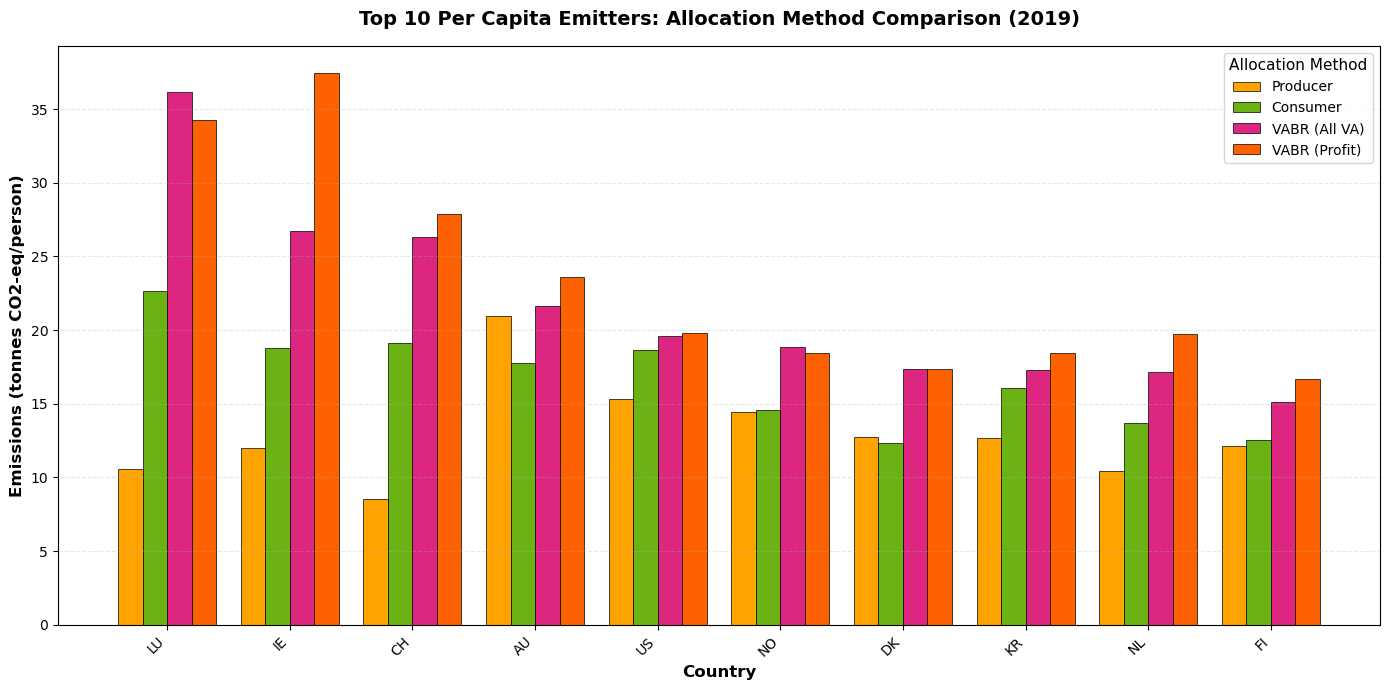


✓ Per capita bar chart created

### Per Capita Summary Statistics ###

Producer:
  Mean:   8.24 tonnes/person
  Median: 7.43 tonnes/person
  Max:    20.98 tonnes/person (AU)

Consumer:
  Mean:   9.60 tonnes/person
  Median: 8.41 tonnes/person
  Max:    22.65 tonnes/person (LU)

VABR (All VA):
  Mean:   11.11 tonnes/person
  Median: 9.97 tonnes/person
  Max:    36.19 tonnes/person (LU)

VABR (Profit):
  Mean:   11.65 tonnes/person
  Median: 10.13 tonnes/person
  Max:    37.42 tonnes/person (IE)

PCPR (All VA):
  Mean:   9.36 tonnes/person
  Median: 8.29 tonnes/person
  Max:    25.07 tonnes/person (LU)

PCPR (Profit):
  Mean:   9.68 tonnes/person
  Median: 8.67 tonnes/person
  Max:    24.42 tonnes/person (LU)

### Per Capita Inequality ###

Producer:
  Top 10 average:    14.55 tonnes/person
  Bottom 10 average: 3.99 tonnes/person
  Ratio (top/bottom): 3.6x

Consumer:
  Top 10 average:    16.83 tonnes/person
  Bottom 10 average: 4.00 tonnes/person
  Ratio (top/bottom): 4.2x

VABR (All VA

In [8]:
# ===================================================================
# ANALYSIS: PER CAPITA EMISSIONS
# ===================================================================

print("\n" + "="*70)
print(f"ANALYSIS 2: Per Capita Emissions ({SINGLE_YEAR})")
print("="*70)

# Use the comparison_df we already created!
# It has: Producer, Consumer, VABR (All VA), VABR (Profit), PCPR (All VA), PCPR (Profit)

# Align with population data (some countries might not have population)
common_countries = comparison_df.index.intersection(population_2022.index)
print(f"\nCountries with population data: {len(common_countries)}/{len(comparison_df)}")

# Create per capita DataFrame (comparison_df is already in Gt, so multiply by 1e9 to get tonnes)
per_capita = pd.DataFrame(index=common_countries)

for method in comparison_df.columns:
    # comparison_df is in Gt, population in persons
    # Gt * 1e9 = tonnes, divided by persons = tonnes/person
    per_capita[method] = (comparison_df.loc[common_countries, method] * 1e9) / population_2022.loc[common_countries]

print(f"Per capita shape: {per_capita.shape}")

# Display top 10 for each approach
print("\n" + "="*70)
print("TOP 10 PER CAPITA EMITTERS (tonnes CO2-eq/person)")
print("="*70)

for method in per_capita.columns:
    print(f"\n{method.upper()}:")
    top10 = per_capita[method].nlargest(10)
    for i, (country, emissions) in enumerate(top10.items(), 1):
        print(f"{i:2d}. {country}: {emissions:6.2f} tonnes/person")

# ===================================================================
# PER CAPITA BAR PLOT - Top 10
# ===================================================================

# Select top 10 countries by VABR (All VA) per capita for consistency
top10_per_capita = per_capita['VABR (All VA)'].nlargest(10).index.tolist()

print(f"\nTop 10 per capita countries: {top10_per_capita}")

# Plot data - select same methods as in absolute comparison
plot_methods = ['Producer', 'Consumer', 'VABR (All VA)', 'VABR (Profit)']
plot_data = per_capita.loc[top10_per_capita, plot_methods]

fig, ax = plt.subplots(figsize=(14, 7))

n_methods = len(plot_methods)
x = np.arange(len(top10_per_capita))
width = 0.2

colors = {
    'Producer': '#ffa300',
    'Consumer': '#6bb314',
    'VABR (All VA)': '#dc267f',
    'VABR (Profit)': '#fe6100'
}

for i, method in enumerate(plot_methods):
    ax.bar(
        x + i * width - (n_methods * width / 2) + (width / 2),
        plot_data[method].values,
        width,
        label=method,
        color=colors[method],
        edgecolor='black',
        linewidth=0.5
    )

ax.set_title(f'Top 10 Per Capita Emitters: Allocation Method Comparison ({SINGLE_YEAR})', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_ylabel('Emissions (tonnes CO2-eq/person)', fontsize=12, fontweight='bold')
ax.set_xlabel('Country', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(top10_per_capita, rotation=45, ha='right', fontsize=10)
ax.legend(title="Allocation Method", fontsize=10, title_fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("\n✓ Per capita bar chart created")

# ===================================================================
# PER CAPITA SUMMARY STATISTICS
# ===================================================================

print("\n### Per Capita Summary Statistics ###")

for method in per_capita.columns:
    mean_val = per_capita[method].mean()
    median_val = per_capita[method].median()
    max_val = per_capita[method].max()
    max_country = per_capita[method].idxmax()
    
    print(f"\n{method}:")
    print(f"  Mean:   {mean_val:.2f} tonnes/person")
    print(f"  Median: {median_val:.2f} tonnes/person")
    print(f"  Max:    {max_val:.2f} tonnes/person ({max_country})")

# ===================================================================
# PER CAPITA INEQUALITY ANALYSIS
# ===================================================================

print("\n### Per Capita Inequality ###")

# Calculate ratios: highest vs lowest emitters
for method in per_capita.columns:
    sorted_vals = per_capita[method].sort_values(ascending=False)
    top10_mean = sorted_vals.head(10).mean()
    bottom10_mean = sorted_vals.tail(10).mean()
    ratio = top10_mean / bottom10_mean
    
    print(f"\n{method}:")
    print(f"  Top 10 average:    {top10_mean:.2f} tonnes/person")
    print(f"  Bottom 10 average: {bottom10_mean:.2f} tonnes/person")
    print(f"  Ratio (top/bottom): {ratio:.1f}x")

# ===================================================================
# COMPARE: Absolute vs Per Capita Rankings
# ===================================================================

print("\n### Absolute vs Per Capita Rankings ###")

# Countries that rank very differently
absolute_ranks = comparison_df['VABR (All VA)'].rank(ascending=False)
per_capita_ranks = per_capita['VABR (All VA)'].rank(ascending=False)

# Find countries in both rankings
common_for_rank = absolute_ranks.index.intersection(per_capita_ranks.index)
rank_diff = (per_capita_ranks.loc[common_for_rank] - 
             absolute_ranks.loc[common_for_rank])

print("\nCountries that rank MUCH HIGHER per capita (small countries with high emissions):")
for country in rank_diff.nsmallest(10).index:
    abs_rank = int(absolute_ranks[country])
    pc_rank = int(per_capita_ranks[country])
    abs_val = comparison_df.loc[country, 'VABR (All VA)']
    pc_val = per_capita.loc[country, 'VABR (All VA)']
    print(f"  {country}: #{abs_rank} absolute → #{pc_rank} per capita "
          f"({abs_val:.2f} Gt vs {pc_val:.1f} t/person)")

print("\nCountries that rank MUCH LOWER per capita (large countries with low per capita):")
for country in rank_diff.nlargest(10).index:
    abs_rank = int(absolute_ranks[country])
    pc_rank = int(per_capita_ranks[country])
    abs_val = comparison_df.loc[country, 'VABR (All VA)']
    pc_val = per_capita.loc[country, 'VABR (All VA)']
    print(f"  {country}: #{abs_rank} absolute → #{pc_rank} per capita "
          f"({abs_val:.2f} Gt vs {pc_val:.1f} t/person)")


RANKING TABLES: Country Rankings by Method

### ABSOLUTE EMISSIONS RANKING ###

Absolute Ranking Table (Top 20):
        Producer    Consumer VABR (All VA) VABR (Profit) PCPR (All VA)  \
Rank                                                                     
1     CN (12.96)  CN (11.82)    CN (11.46)    CN (11.04)    CN (12.91)   
2      US (5.10)   US (6.21)     US (6.52)     US (6.59)     US (5.29)   
3      WA (3.52)   WA (3.70)     WA (3.07)     IN (2.96)     IN (3.39)   
4      IN (3.45)   IN (3.17)     IN (2.90)     WM (2.77)     WA (3.32)   
5      WM (3.06)   WM (2.54)     WM (2.45)     WA (2.37)     WM (2.69)   
6      WF (2.24)   WF (2.22)     WF (1.88)     WF (1.88)     WF (2.10)   
7      RU (2.04)   RU (1.55)     JP (1.69)     JP (1.68)     RU (1.72)   
8      WL (1.33)   JP (1.44)     RU (1.52)     RU (1.61)     JP (1.32)   
9      BR (1.18)   WL (1.30)     WL (1.25)     DE (1.21)     WL (1.26)   
10     ID (1.07)   BR (1.06)     DE (1.22)     WL (1.19)     BR (1.19)  

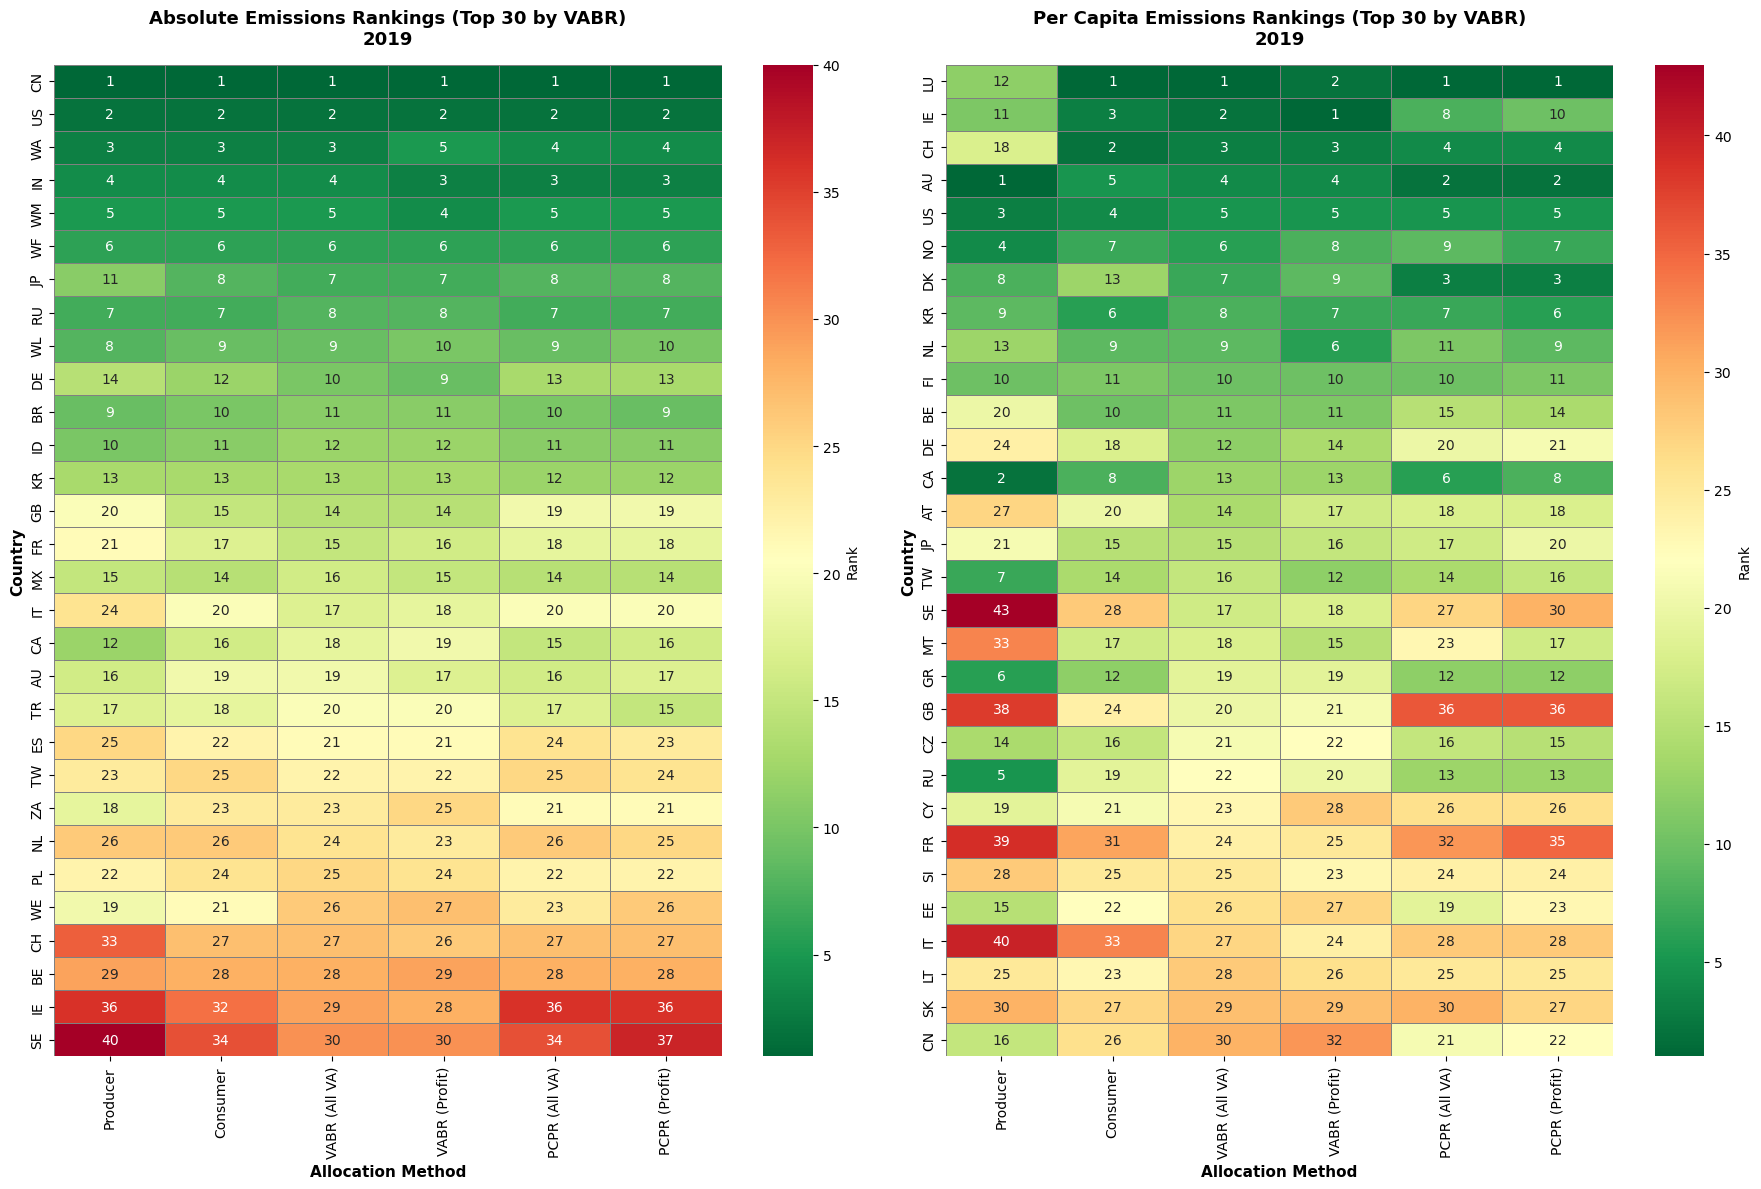


✓ Ranking heatmaps created and saved

### Ranking Stability Analysis ###

ABSOLUTE RANKINGS:

Most stable rankings (5 countries with smallest rank variation):
  WF: ranks [6. 6. 6. 6. 6. 6.], std=0.00
  MT: ranks [49. 49. 49. 49. 49. 49.], std=0.00
  US: ranks [2. 2. 2. 2. 2. 2.], std=0.00
  CN: ranks [1. 1. 1. 1. 1. 1.], std=0.00
  SK: ranks [41. 40. 40. 40. 40. 40.], std=0.41

Most volatile rankings (5 countries with largest rank variation):
  CH: ranks [33. 27. 27. 26. 27. 27.], range #26-#33, std=2.56
  GB: ranks [20. 15. 14. 14. 19. 19.], range #14-#20, std=2.79
  WE: ranks [19. 21. 26. 27. 23. 26.], range #19-#27, std=3.20
  IE: ranks [36. 32. 29. 28. 36. 36.], range #28-#36, std=3.71
  SE: ranks [40. 34. 30. 30. 34. 37.], range #30-#40, std=3.92

PER CAPITA RANKINGS:

Most stable rankings (5 countries with smallest rank variation):
  IN: ranks [48. 48. 48. 48. 48. 48.], std=0.00
  WA: ranks [47. 47. 47. 47. 47. 47.], std=0.00
  WF: ranks [49. 49. 49. 49. 49. 49.], std=0.00
  WL

Ellipsis

In [ ]:
# ===================================================================
# RANKING TABLES - ABSOLUTE AND PER CAPITA
# ===================================================================

print("\n" + "="*70)
print("RANKING TABLES: Country Rankings by Method")
print("="*70)

# ===================================================================
# 1. ABSOLUTE EMISSIONS RANKING TABLE
# ===================================================================

print("\n### ABSOLUTE EMISSIONS RANKING ###")

# Calculate ranks (already have this from before, but recalculate to be sure)
absolute_ranks = comparison_df.rank(ascending=False, method='min')

# Create ranking table: rows are ranks, columns are methods
n_countries = len(comparison_df)
n_methods = len(comparison_df.columns)

# Initialize empty DataFrame
absolute_ranking_table = pd.DataFrame(
    index=range(1, n_countries + 1),
    columns=comparison_df.columns
)
absolute_ranking_table.index.name = 'Rank'

# Fill table: for each method, sort countries by rank
for method in comparison_df.columns:
    # Sort countries by their emissions (highest first)
    sorted_countries = comparison_df[method].sort_values(ascending=False)
    
    # Assign country names to ranks
    for rank, (country, value) in enumerate(sorted_countries.items(), start=1):
        absolute_ranking_table.loc[rank, method] = f"{country} ({value:.2f})"

print("\nAbsolute Ranking Table (Top 20):")
print(absolute_ranking_table.head(20))

# Save to CSV
absolute_ranking_table.to_csv(RESULTS_PATH / f'absolute_ranking_table_{SINGLE_YEAR}.csv')
print(f"\n✓ Saved to: {RESULTS_PATH / f'absolute_ranking_table_{SINGLE_YEAR}.csv'}")

# ===================================================================
# 2. PER CAPITA EMISSIONS RANKING TABLE
# ===================================================================

print("\n### PER CAPITA EMISSIONS RANKING ###")

# Calculate ranks for per capita data
per_capita_ranks = per_capita.rank(ascending=False, method='min')

n_countries_pc = len(per_capita)

# Initialize empty DataFrame
per_capita_ranking_table = pd.DataFrame(
    index=range(1, n_countries_pc + 1),
    columns=per_capita.columns
)
per_capita_ranking_table.index.name = 'Rank'

# Fill table: for each method, sort countries by rank
for method in per_capita.columns:
    # Sort countries by their per capita emissions (highest first)
    sorted_countries = per_capita[method].sort_values(ascending=False)
    
    # Assign country names to ranks
    for rank, (country, value) in enumerate(sorted_countries.items(), start=1):
        per_capita_ranking_table.loc[rank, method] = f"{country} ({value:.2f})"

print("\nPer Capita Ranking Table (Top 20):")
print(per_capita_ranking_table.head(20))

# Save to CSV
per_capita_ranking_table.to_csv(RESULTS_PATH / f'per_capita_ranking_table_{SINGLE_YEAR}.csv')
print(f"\n✓ Saved to: {RESULTS_PATH / f'per_capita_ranking_table_{SINGLE_YEAR}.csv'}")

# ===================================================================
# 3. VISUAL REPRESENTATION - HEATMAP STYLE (OPTIONAL)
# ===================================================================

print("\n### Creating Visual Ranking Heatmaps ###")

# For visual heatmap, we just show rank numbers (not country names)
# This makes it easier to see patterns

# ABSOLUTE RANKINGS HEATMAP (Top 30)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 12))

# Get rank numbers for heatmap
absolute_rank_numbers = absolute_ranks.copy()
absolute_rank_numbers = absolute_rank_numbers.sort_values(by='VABR (All VA)')

# Show top 30 countries only
top30_absolute = absolute_rank_numbers.head(30)

# Create heatmap
sns.heatmap(
    top30_absolute,
    annot=True,
    fmt='.0f',
    cmap='RdYlGn_r',  # Green = high rank (worse), Red = low rank (better)
    cbar_kws={'label': 'Rank'},
    ax=ax1,
    linewidths=0.5,
    linecolor='gray'
)

ax1.set_title(f'Absolute Emissions Rankings (Top 30 by VABR)\n{SINGLE_YEAR}',
              fontsize=13, fontweight='bold', pad=15)
ax1.set_xlabel('Allocation Method', fontsize=11, fontweight='bold')
ax1.set_ylabel('Country', fontsize=11, fontweight='bold')

# PER CAPITA RANKINGS HEATMAP (Top 30)
per_capita_rank_numbers = per_capita_ranks.copy()
per_capita_rank_numbers = per_capita_rank_numbers.sort_values(by='VABR (All VA)')

# Show top 30 countries only
top30_per_capita = per_capita_rank_numbers.head(30)

sns.heatmap(
    top30_per_capita,
    annot=True,
    fmt='.0f',
    cmap='RdYlGn_r',
    cbar_kws={'label': 'Rank'},
    ax=ax2,
    linewidths=0.5,
    linecolor='gray'
)

ax2.set_title(f'Per Capita Emissions Rankings (Top 30 by VABR)\n{SINGLE_YEAR}',
              fontsize=13, fontweight='bold', pad=15)
ax2.set_xlabel('Allocation Method', fontsize=11, fontweight='bold')
ax2.set_ylabel('Country', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(RESULTS_PATH / f'ranking_heatmaps_{SINGLE_YEAR}.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Ranking heatmaps created and saved")

# ===================================================================
# 4. SUMMARY STATISTICS - RANK CHANGES
# ===================================================================

print("\n### Ranking Stability Analysis ###")

# For absolute rankings
print("\nABSOLUTE RANKINGS:")
rank_std_absolute = absolute_ranks.std(axis=1).sort_values()

print("\nMost stable rankings (5 countries with smallest rank variation):")
for country in rank_std_absolute.head(5).index:
    ranks_list = absolute_ranks.loc[country].values
    print(f"  {country}: ranks {ranks_list}, std={rank_std_absolute[country]:.2f}")

print("\nMost volatile rankings (5 countries with largest rank variation):")
for country in rank_std_absolute.tail(5).index:
    ranks_list = absolute_ranks.loc[country].values
    min_rank = int(ranks_list.min())
    max_rank = int(ranks_list.max())
    print(f"  {country}: ranks {ranks_list}, range #{min_rank}-#{max_rank}, std={rank_std_absolute[country]:.2f}")

# For per capita rankings
print("\nPER CAPITA RANKINGS:")
rank_std_per_capita = per_capita_ranks.std(axis=1).sort_values()

print("\nMost stable rankings (5 countries with smallest rank variation):")
for country in rank_std_per_capita.head(5).index:
    ranks_list = per_capita_ranks.loc[country].values
    print(f"  {country}: ranks {ranks_list}, std={rank_std_per_capita[country]:.2f}")

print("\nMost volatile rankings (5 countries with largest rank variation):")
for country in rank_std_per_capita.tail(5).index:
    ranks_list = per_capita_ranks.loc[country].values
    min_rank = int(ranks_list.min())
    max_rank = int(ranks_list.max())
    print(f"  {country}: ranks {ranks_list}, range #{min_rank}-#{max_rank}, std={rank_std_per_capita[country]:.2f}")

# ===================================================================
# 5. EXPORT FULL TABLES TO EXCEL
# ===================================================================

print("\n### Exporting to Excel ###")

with pd.ExcelWriter(RESULTS_PATH / f'ranking_tables_{SINGLE_YEAR}.xlsx') as writer:
    # Sheet 1: Absolute rankings
    absolute_ranking_table.to_excel(writer, sheet_name='Absolute Rankings')
    
    # Sheet 2: Per capita rankings
    per_capita_ranking_table.to_excel(writer, sheet_name='Per Capita Rankings')
    
    # Sheet 3: Absolute rank numbers (for further analysis)
    absolute_ranks.to_excel(writer, sheet_name='Absolute Rank Numbers')
    
    # Sheet 4: Per capita rank numbers
    per_capita_ranks.to_excel(writer, sheet_name='Per Capita Rank Numbers')
    
    # Sheet 5: Summary statistics
    summary_df = pd.DataFrame({
        'Absolute_Mean_Rank': absolute_ranks.mean(),
        'Absolute_Std_Rank': absolute_ranks.std(),
        'PerCapita_Mean_Rank': per_capita_ranks.mean(),
        'PerCapita_Std_Rank': per_capita_ranks.std()
    })
    summary_df.to_excel(writer, sheet_name='Summary')

print(f"✓ Saved comprehensive Excel file to: {RESULTS_PATH / f'ranking_tables_{SINGLE_YEAR}.xlsx'}")

print("\n" + "="*70)
print("✓ ALL RANKING TABLES COMPLETE")
print("="*70)
...


ANALYSIS 3: World Map - Dominant Method per Capita (2019)

Countries by dominant method:
VABR        30
Producer    14
Consumer     5
Name: dominant_method, dtype: int64

Expanded to 227 countries/territories
Countries with data: 161


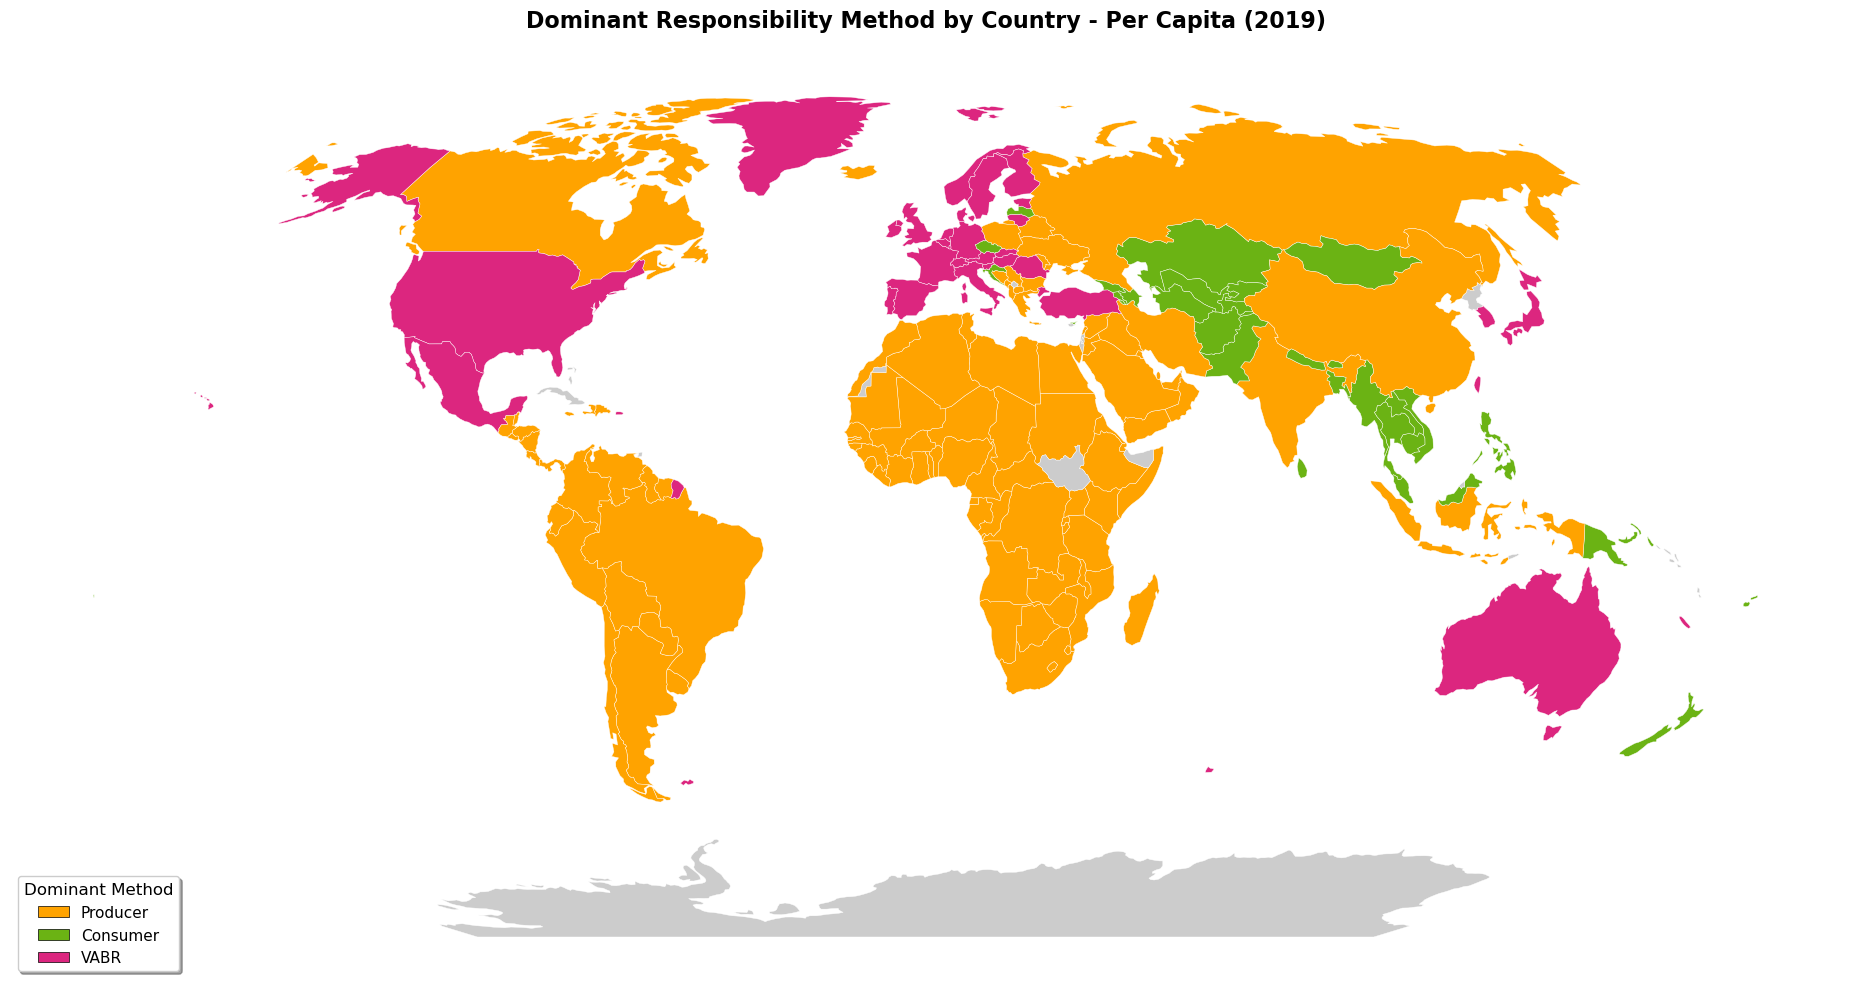


✓ World map created

Countries by dominant method:
Producer    98
VABR        34
Consumer    29
Name: dominant_method, dtype: int64


In [11]:
# ===================================================================
# ANALYSIS 3: WORLD MAP - DOMINANT RESPONSIBILITY METHOD
# ===================================================================

print("\n" + "="*70)
print(f"ANALYSIS 3: World Map - Dominant Method per Capita ({SINGLE_YEAR})")
print("="*70)

import geopandas as gpd
from matplotlib.patches import Rectangle

# ===================================================================
# PREPARE DATA: Determine dominant method for each country
# ===================================================================

# Create DataFrame with all methods
map_input = pd.DataFrame({
    'Producer': per_capita['Producer'],
    'Consumer': per_capita['Consumer'],
    'VABR': per_capita['VABR (Profit)']  # or whichever VABR variant you want
})

# Find dominant method for each country
map_input['dominant_method'] = map_input[['Producer', 'Consumer', 'VABR']].idxmax(axis=1)
map_input['max_value'] = map_input[['Producer', 'Consumer', 'VABR']].max(axis=1)

print(f"\nCountries by dominant method:")
print(map_input['dominant_method'].value_counts())

# ===================================================================
# COUNTRY CODE MAPPING
# ===================================================================

# EXIOBASE country codes to shapefile SOV_A3 codes
exiobase_to_sov = {
    'AT': 'AUT', 'BE': 'BEL', 'BG': 'BGR', 'CY': 'CYN', 'CZ': 'CZE',
    'DE': 'DEU', 'DK': 'DN1', 'EE': 'EST', 'ES': 'ESP', 'FI': 'FI1',
    'FR': 'FR1', 'GR': 'GRC', 'HR': 'HRV', 'HU': 'HUN', 'IE': 'IRL',
    'IT': 'ITA', 'LT': 'LTU', 'LU': 'LUX', 'LV': 'LVA', 'MT': 'MLT',
    'NL': 'NL1', 'PL': 'POL', 'PT': 'PRT', 'RO': 'ROU', 'SE': 'SWE',
    'SI': 'SVN', 'SK': 'SVK', 'GB': 'GB1', 'US': 'US1', 'JP': 'JPN',
    'CN': 'CH1', 'CA': 'CAN', 'KR': 'KOR', 'BR': 'BRA', 'IN': 'IND',
    'MX': 'MEX', 'RU': 'RUS', 'AU': 'AU1', 'CH': 'CHE', 'TR': 'TUR',
    'TW': 'TWN', 'NO': 'NOR', 'ID': 'IDN', 'ZA': 'ZAF'
}

# ISO2 to SOV_A3 for ROW regions
iso2_to_sov = {
    'AF': 'AFG', 'AL': 'ALB', 'DZ': 'DZA', 'AO': 'AGO', 'AR': 'ARG',
    'AM': 'ARM', 'AZ': 'AZE', 'BD': 'BGD', 'BH': 'BHR', 'BY': 'BLR',
    'BZ': 'BLZ', 'BJ': 'BEN', 'BT': 'BTN', 'BO': 'BOL', 'BA': 'BIH',
    'BW': 'BWA', 'BF': 'BFA', 'BI': 'BDI', 'KH': 'KHM', 'CM': 'CMR',
    'CV': 'CPV', 'CF': 'CAF', 'TD': 'TCD', 'CL': 'CHL', 'CO': 'COL',
    'KM': 'COM', 'CG': 'COG', 'CD': 'COD', 'CR': 'CRI', 'CI': 'CIV',
    'CU': 'CUB', 'DJ': 'DJI', 'DO': 'DOM', 'EC': 'ECU', 'EG': 'EGY',
    'SV': 'SLV', 'GQ': 'GNQ', 'ER': 'ERI', 'ET': 'ETH', 'FJ': 'FJI',
    'GA': 'GAB', 'GM': 'GMB', 'GE': 'GEO', 'GH': 'GHA', 'GT': 'GTM',
    'GN': 'GIN', 'GW': 'GNB', 'GY': 'GUY', 'HT': 'HTI', 'HN': 'HND',
    'IS': 'ISL', 'IR': 'IRN', 'IQ': 'IRQ', 'IL': 'ISR', 'JM': 'JAM',
    'JO': 'JOR', 'KE': 'KEN', 'KW': 'KWT', 'KG': 'KGZ', 'LA': 'LAO',
    'LB': 'LBN', 'LS': 'LSO', 'LR': 'LBR', 'LY': 'LBY', 'MK': 'MKD',
    'MG': 'MDG', 'MW': 'MWI', 'MY': 'MYS', 'MV': 'MDV', 'ML': 'MLI',
    'MR': 'MRT', 'MU': 'MUS', 'MD': 'MDA', 'MN': 'MNG', 'ME': 'MNE',
    'MA': 'MAR', 'MZ': 'MOZ', 'MM': 'MMR', 'NA': 'NAM', 'NP': 'NPL',
    'NZ': 'NZ1', 'NI': 'NIC', 'NE': 'NER', 'NG': 'NGA', 'OM': 'OMN',
    'PK': 'PAK', 'PA': 'PAN', 'PG': 'PNG', 'PY': 'PRY', 'PE': 'PER',
    'PH': 'PHL', 'QA': 'QAT', 'RW': 'RWA', 'SA': 'SAU', 'SN': 'SEN',
    'RS': 'SRB', 'SC': 'SYC', 'SL': 'SLE', 'SG': 'SGP', 'SO': 'SOM',
    'LK': 'LKA', 'SD': 'SDN', 'SR': 'SUR', 'SZ': 'SWZ', 'SY': 'SYR',
    'TJ': 'TJK', 'TZ': 'TZA', 'TH': 'THA', 'TG': 'TGO', 'TN': 'TUN',
    'TM': 'TKM', 'UG': 'UGA', 'UA': 'UKR', 'AE': 'ARE', 'UY': 'URY',
    'UZ': 'UZB', 'VE': 'VEN', 'VN': 'VNM', 'YE': 'YEM', 'ZM': 'ZMB',
    'ZW': 'ZWE', 'KZ': 'KA1'
}

# ROW regions and their member countries
row_regions = {
    'WA': ['AF', 'AS', 'AM', 'AZ', 'BD', 'BT', 'BN', 'KH', 'CK', 'FJ', 'PF', 'GE',
           'GU', 'HK', 'KZ', 'KI', 'KP', 'KG', 'LA', 'MO', 'MY', 'MV', 'MH', 'FM',
           'MN', 'MM', 'NR', 'NP', 'NC', 'NZ', 'NU', 'MP', 'PK', 'PW', 'PG', 'PH',
           'PN', 'WS', 'SG', 'SB', 'LK', 'TJ', 'TH', 'TP', 'TK', 'TO', 'TM', 'TV',
           'UZ', 'VU', 'VN'],
    'WL': ['AI', 'AG', 'AR', 'AW', 'BS', 'BB', 'BZ', 'BM', 'BO', 'KY', 'CL', 'CO',
           'CR', 'CU', 'DM', 'DO', 'EC', 'SV', 'FK', 'GL', 'GD', 'GP', 'GT', 'GY',
           'HT', 'HN', 'JM', 'MQ', 'NI', 'PA', 'PY', 'PE', 'PR', 'KN', 'LC', 'PM',
           'VC', 'SR', 'TT', 'TC', 'UY', 'VE', 'VG', 'VI', 'GF'],
    'WE': ['AL', 'AD', 'BY', 'BA', 'FO', 'GI', 'IS', 'IM', 'LI', 'MK', 'MD', 'MC',
           'ME', 'SM', 'RS', 'UA', 'VA'],
    'WF': ['DZ', 'AO', 'BJ', 'BW', 'BF', 'BI', 'CM', 'CV', 'CF', 'TD', 'KM', 'CD',
           'CG', 'CI', 'DJ', 'GQ', 'EH', 'ER', 'ET', 'GA', 'GM', 'GH', 'GN', 'GW', 'KE',
           'LS', 'LR', 'LY', 'MG', 'MW', 'ML', 'MR', 'MU', 'YT', 'MA', 'MZ', 'NA',
           'NE', 'NG', 'RE', 'RW', 'ST', 'SN', 'SC', 'SL', 'SO', 'SH', 'SD', 'SZ',
           'TZ', 'TG', 'TN', 'UG', 'ZM', 'ZW'],
    'WM': ['BH', 'IR', 'IQ', 'IL', 'JO', 'KW', 'LB', 'OM', 'PS', 'QA', 'SA',
           'SY', 'AE', 'YE', 'EG']
}

# ===================================================================
# EXPAND DATA: Map EXIOBASE countries and ROW regions to shapefile
# ===================================================================

map_data = []

for country_code, row_data in map_input.iterrows():
    if country_code in exiobase_to_sov:
        # Individual EXIOBASE country
        map_data.append({
            'SOV_A3': exiobase_to_sov[country_code],
            'dominant_method': row_data['dominant_method'],
            'max_value': row_data['max_value'],
            'Producer': row_data['Producer'],
            'Consumer': row_data['Consumer'],
            'VABR': row_data['VABR']
        })
    elif country_code in row_regions:
        # ROW region - assign to all member countries
        for member_iso2 in row_regions[country_code]:
            member_sov = iso2_to_sov.get(member_iso2, member_iso2)
            map_data.append({
                'SOV_A3': member_sov,
                'dominant_method': row_data['dominant_method'],
                'max_value': row_data['max_value'],
                'Producer': row_data['Producer'],
                'Consumer': row_data['Consumer'],
                'VABR': row_data['VABR']
            })

map_df = pd.DataFrame(map_data)
print(f"\nExpanded to {len(map_df)} countries/territories")

# ===================================================================
# LOAD SHAPEFILE AND MERGE
# ===================================================================

# Load world shapefile
shapefile_path = BASE_PATH / "results" / "geodata" / "ne_110m_admin_0_countries" / "ne_110m_admin_0_countries.shp"
world = gpd.read_file(shapefile_path)
world = world.to_crs('ESRI:54030')  # Robinson projection

# Merge data
world = world.merge(map_df, on='SOV_A3', how='left')

print(f"Countries with data: {world['dominant_method'].notna().sum()}")

# ===================================================================
# CREATE MAP
# ===================================================================

fig, ax = plt.subplots(1, 1, figsize=(20, 10))

# Method colors
method_colors = {
    'Producer': '#ffa300',
    'Consumer': '#6bb314',
    'VABR': '#dc267f'
}

# Assign colors
world['color'] = world['dominant_method'].map(method_colors)
world['color'] = world['color'].fillna('#CCCCCC')  # Gray for missing data

# Plot
world.plot(
    color=world['color'],
    linewidth=0.3,
    edgecolor='white',
    ax=ax,
    missing_kwds={'color': '#CCCCCC', 'edgecolor': 'white', 'linewidth': 0.3}
)

# Ocean background
ax.set_facecolor('#E6F3FF')
ax.axis('off')

# Title
ax.set_title(
    f'Dominant Responsibility Method by Country - Per Capita ({SINGLE_YEAR})',
    fontsize=16, fontweight='bold', pad=20
)

# Legend
legend_elements = [
    Rectangle((0, 0), 1, 1, fc='#ffa300', edgecolor='black', linewidth=0.5, label='Producer'),
    Rectangle((0, 0), 1, 1, fc='#6bb314', edgecolor='black', linewidth=0.5, label='Consumer'),
    Rectangle((0, 0), 1, 1, fc='#dc267f', edgecolor='black', linewidth=0.5, label='VABR')
]

ax.legend(
    handles=legend_elements,
    loc='lower left',
    title='Dominant Method',
    frameon=True,
    fancybox=True,
    shadow=True,
    fontsize=11,
    title_fontsize=12
)

plt.tight_layout()
plt.show()

print("\n✓ World map created")
print(f"\nCountries by dominant method:")
print(world['dominant_method'].value_counts())

In [ ]:
# ===================================================================
# ANALYSIS: EFFICIENCY BIAS INVESTIGATION
# ===================================================================

print("\n" + "="*70)
print(f"ANALYSIS 4: Efficiency Bias Investigation ({SINGLE_YEAR})")
print("="*70)

# ===================================================================
# STEP 1: Calculate metrics for all sector-regions
# ===================================================================

print("\n### STEP 1: Calculate Metrics ###")

# Get basic data
n_sectors = len(ixi_data.x)
total_output = ixi_data.x.values.flatten()
regions = ixi_data.get_regions()
sectors = ixi_data.get_sectors()

# Calculate emission intensity (kg CO2-eq per EUR output)
emission_intensity = np.divide(
    producer_emissions,
    total_output,
    out=np.zeros_like(producer_emissions),
    where=(total_output != 0)
)

# VA coefficient (we already have v_clean_all)
va_coefficient = v_clean_all

# Get producer and VABR responsibilities in tonnes
producer_resp = producer_emissions.copy()
vabr_resp = vabr_all.reindex(ixi_data.x.index).values  # Align with x index

# Create DataFrame
bias_df = pd.DataFrame({
    'region': ixi_data.x.index.get_level_values(0),
    'sector': ixi_data.x.index.get_level_values(1),
    'total_emissions': producer_resp / 1e9,  # Convert to Gt
    'emission_intensity': emission_intensity,
    'va_coefficient': va_coefficient,
    'output': total_output,
    'producer_resp': producer_resp / 1e9,  # Gt
    'vabr_resp': vabr_resp / 1e9  # Gt
}, index=ixi_data.x.index)

# Add sector category
bias_df['category'] = bias_df['sector'].apply(category_of)

print(f"Total sector-regions: {len(bias_df)}")
print(f"\nSummary statistics:")
print(bias_df[['emission_intensity', 'va_coefficient', 'total_emissions']].describe())

In [ ]:
# ===================================================================
# STEP 2: Filter by emission threshold
# ===================================================================

print("\n### STEP 2: Apply Threshold Filter ###")

# Calculate global emission share
total_global_emissions = bias_df['total_emissions'].sum()
bias_df['emission_share'] = (bias_df['total_emissions'] / total_global_emissions) * 100

# Filter: only sector-regions with > 0.01% of global emissions
threshold = 0.01  # percent
bias_df_filtered = bias_df[bias_df['emission_share'] > threshold].copy()

print(f"Threshold: > {threshold}% of global emissions")
print(f"Sector-regions after filter: {len(bias_df_filtered)} (from {len(bias_df)})")
print(f"Coverage: {bias_df_filtered['total_emissions'].sum() / total_global_emissions * 100:.1f}% of global emissions")

# Sort by total emissions
bias_df_filtered = bias_df_filtered.sort_values('total_emissions', ascending=False)

print(f"\nTop 10 emitters:")
print(bias_df_filtered[['region', 'sector', 'total_emissions', 'emission_intensity', 'va_coefficient']].head(10))

In [ ]:
# ===================================================================
# STEP 3: Explore patterns
# ===================================================================

print("\n### STEP 3: Pattern Exploration ###")

# A) Group by category - which sectors most affected?
category_summary = bias_df_filtered.groupby('category').agg({
    'total_emissions': 'sum',
    'emission_intensity': 'mean',
    'va_coefficient': 'mean'
}).sort_values('total_emissions', ascending=False)

print("\nEmissions by sector category:")
print(category_summary.head(15))

# B) Identify problematic sector-regions (high emissions, low VA)
# Define "problematic": emission_intensity > median AND va_coefficient < median
median_emis = bias_df_filtered['emission_intensity'].median()
median_va = bias_df_filtered['va_coefficient'].median()

problematic = bias_df_filtered[
    (bias_df_filtered['emission_intensity'] > median_emis) &
    (bias_df_filtered['va_coefficient'] < median_va)
].copy()

print(f"\n### Problematic sector-regions (high emissions, low VA): {len(problematic)} ###")
print("\nTop 20 most problematic:")
print(problematic[['region', 'sector', 'total_emissions', 'emission_intensity', 'va_coefficient']].head(20))

# C) By category - which categories in problematic zone?
print("\nProblematic sector-regions by category:")
print(problematic['category'].value_counts())

In [ ]:
# ===================================================================
# QUICK CHECK: Waste & Recycling Anomaly
# ===================================================================

print("\n" + "="*70)
print("WASTE & RECYCLING INVESTIGATION")
print("="*70)

# Filter for waste sectors
waste_sectors = bias_df_filtered[bias_df_filtered['category'] == 'Waste & Recycling'].copy()

print(f"\nWaste & Recycling sector-regions in filtered data: {len(waste_sectors)}")
print(f"\nSorted by emission intensity (highest first):")
print(waste_sectors[['region', 'sector', 'total_emissions', 'emission_intensity', 'va_coefficient', 'output']].sort_values('emission_intensity', ascending=False).head(20))

# Check for extreme outliers
print(f"\n### Outlier Analysis ###")
print(f"Max emission intensity in waste: {waste_sectors['emission_intensity'].max():.2e}")
print(f"Median emission intensity in waste: {waste_sectors['emission_intensity'].median():.2f}")
print(f"Mean emission intensity in waste: {waste_sectors['emission_intensity'].mean():.2e}")

# Check specific problematic sectors
extreme_waste = waste_sectors[waste_sectors['emission_intensity'] > 1e6]
print(f"\nExtreme outliers (emission intensity > 1 million):")
if len(extreme_waste) > 0:
    print(extreme_waste[['region', 'sector', 'total_emissions', 'emission_intensity', 'output']])
    
    # Investigate: is it because output is very low?
    print("\nInvestigating cause:")
    for idx, row in extreme_waste.iterrows():
        print(f"\n{row['region']} - {row['sector'][:50]}...")
        print(f"  Emissions: {row['total_emissions']:.6f} Gt")
        print(f"  Output: {row['output']:.2f} million EUR")
        print(f"  Ratio: {row['total_emissions']*1e9 / row['output'] if row['output'] > 0 else 'DIV BY ZERO':.2f} kg/EUR")
else:
    print("No extreme outliers found")

# Compare to other sectors
print(f"\n### Comparison to other categories ###")
print("Median emission intensity by category (top 10):")
category_medians = bias_df_filtered.groupby('category')['emission_intensity'].median().sort_values(ascending=False)
print(category_medians.head(10))

In [ ]:
# Check: Are there other sectors with very low output?
print("\n### Sectors with very low output (< 1 million EUR) ###")
low_output = bias_df_filtered[bias_df_filtered['output'] < 1.0].copy()
print(f"Sectors with output < 1 million EUR: {len(low_output)}")
print("\nBy category:")
print(low_output['category'].value_counts())

print("\nTop 20 by emission intensity:")
print(low_output.nlargest(20, 'emission_intensity')[['region', 'sector', 'total_emissions', 'emission_intensity', 'output']])

In [ ]:
# Check specific waste sectors
print("\n### Waste Sectors VA Cleaning Details ###")

waste_check = bias_df[bias_df['category'] == 'Waste & Recycling'].copy()

# Add more details
waste_check['absolute_va'] = waste_check['va_coefficient'] * waste_check['output']

print("\nWaste sectors with output < 1:")
print(waste_check[waste_check['output'] < 1.0][
    ['region', 'sector', 'output', 'va_coefficient', 'absolute_va', 'total_emissions']
].sort_values('output'))

print("\nWaste sectors with output > 10:")
print(waste_check[waste_check['output'] > 10.0][
    ['region', 'sector', 'output', 'va_coefficient', 'absolute_va', 'total_emissions']
].sort_values('output', ascending=False).head(10))



In [ ]:
# ===================================================================
# ANALYSIS 5: EFFICIENCY BIAS QUADRANT PLOT
# ===================================================================

print("\n" + "="*70)
print(f"ANALYSIS 5: Efficiency Bias Visualization ({SINGLE_YEAR})")
print("="*70)

# ===================================================================
# CONFIGURATION
# ===================================================================

INCLUDE_WASTE = False  # Set to True to include waste sectors

# ===================================================================
# PREPARE PLOT DATA
# ===================================================================

if INCLUDE_WASTE:
    plot_data = bias_df_filtered.copy()
    title_suffix = ""
    print("Including waste sectors in plot")
else:
    plot_data = bias_df_filtered[
        bias_df_filtered['category'] != 'Waste & Recycling'
    ].copy()
    title_suffix = " (excluding Waste & Recycling)"
    print("Excluding waste sectors from plot")

print(f"Sectors in plot: {len(plot_data)}")
print(f"Total emissions covered: {plot_data['total_emissions'].sum():.2f} Gt")

# ===================================================================
# CREATE PLOT
# ===================================================================

fig, ax = plt.subplots(figsize=(14, 10))

# Get unique categories and assign colors
categories = plot_data['category'].unique()
colors_map = {cat: sector_colours.get(cat, '#9edae5') for cat in categories}

# Plot each category separately for legend
for category in categories:
    cat_data = plot_data[plot_data['category'] == category]
    
    ax.scatter(
        cat_data['va_coefficient'],
        cat_data['emission_intensity'],
        c=colors_map[category],
        label=category,
        s=50,  # Fixed size for all points
        alpha=0.6,
        edgecolors='black',
        linewidths=0.3
    )

# Set y-axis to log scale
ax.set_yscale('log')

# Labels and title
ax.set_xlabel('Value-Added Coefficient', fontsize=12, fontweight='bold')
ax.set_ylabel('Emission Intensity (kg CO2-eq / EUR)', fontsize=12, fontweight='bold')
ax.set_title(
    f'Efficiency Bias: Emission Intensity vs. Value-Added{title_suffix}\n({SINGLE_YEAR})',
    fontsize=14,
    fontweight='bold',
    pad=20
)

# Grid
ax.grid(True, alpha=0.3, linestyle='--')

# Legend
ax.legend(
    title='Sector Category',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    frameon=True,
    fontsize=9,
    title_fontsize=10
)

# Set x-axis limits
ax.set_xlim(-0.05, 1.05)

plt.tight_layout()
plt.show()

print("\n✓ Quadrant plot created")

# ===================================================================
# SUMMARY STATISTICS
# ===================================================================

print("\n### Plot Statistics ###")
print(f"X-axis (VA coefficient) range: {plot_data['va_coefficient'].min():.2f} to {plot_data['va_coefficient'].max():.2f}")
print(f"Y-axis (Emission intensity) range: {plot_data['emission_intensity'].min():.2f} to {plot_data['emission_intensity'].max():.2f}")

print("\nSectors by quadrant (using medians as dividers):")
median_va = plot_data['va_coefficient'].median()
median_emis = plot_data['emission_intensity'].median()

print(f"Median VA coefficient: {median_va:.2f}")
print(f"Median emission intensity: {median_emis:.2f}")

# Count sectors in each quadrant
high_emis_low_va = plot_data[
    (plot_data['emission_intensity'] > median_emis) & 
    (plot_data['va_coefficient'] < median_va)
]
high_emis_high_va = plot_data[
    (plot_data['emission_intensity'] > median_emis) & 
    (plot_data['va_coefficient'] >= median_va)
]
low_emis_low_va = plot_data[
    (plot_data['emission_intensity'] <= median_emis) & 
    (plot_data['va_coefficient'] < median_va)
]
low_emis_high_va = plot_data[
    (plot_data['emission_intensity'] <= median_emis) & 
    (plot_data['va_coefficient'] >= median_va)
]

print(f"\nHigh emissions, Low VA (BIAS ZONE): {len(high_emis_low_va)} sectors ({high_emis_low_va['total_emissions'].sum():.2f} Gt)")
print(f"High emissions, High VA: {len(high_emis_high_va)} sectors ({high_emis_high_va['total_emissions'].sum():.2f} Gt)")
print(f"Low emissions, Low VA: {len(low_emis_low_va)} sectors ({low_emis_low_va['total_emissions'].sum():.2f} Gt)")
print(f"Low emissions, High VA (Services): {len(low_emis_high_va)} sectors ({low_emis_high_va['total_emissions'].sum():.2f} Gt)")

print(f"\nTop 5 sectors in BIAS ZONE:")
print(high_emis_low_va.nlargest(5, 'total_emissions')[
    ['region', 'sector', 'total_emissions', 'emission_intensity', 'va_coefficient']
])

In [ ]:
# ===================================================================
# PLOT 1: TOP 30 EMITTERS - DETAILED SCATTER
# ===================================================================

print("\n" + "="*70)
print("PLOT 1: Top 30 Emitting Sectors - Efficiency Bias Analysis")
print("="*70)

# Select top 30 by total emissions
top30 = plot_data.nlargest(30, 'total_emissions').copy()

print(f"Top 30 sectors represent: {top30['total_emissions'].sum():.2f} Gt ({top30['total_emissions'].sum()/plot_data['total_emissions'].sum()*100:.1f}% of filtered total)")

# Create figure
fig, ax = plt.subplots(figsize=(16, 10))

# Plot each category
for category in top30['category'].unique():
    cat_data = top30[top30['category'] == category]
    
    ax.scatter(
        cat_data['va_coefficient'],
        cat_data['emission_intensity'],
        c=[colors_map[category]],
        label=category,
        s=cat_data['total_emissions'] * 200,  # Size by emissions
        alpha=0.7,
        edgecolors='black',
        linewidths=0.5
    )

# Add labels for each point
for idx, row in top30.iterrows():
    region = row['region']
    sector_short = row['sector'][:30]  # Truncate long names
    
    # Offset text slightly to avoid overlap
    ax.annotate(
        f"{region}-{sector_short}",
        xy=(row['va_coefficient'], row['emission_intensity']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=7,
        alpha=0.8,
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='none')
    )

# Set y-axis to log scale
ax.set_yscale('log')

# Labels and title
ax.set_xlabel('Value-Added Coefficient', fontsize=13, fontweight='bold')
ax.set_ylabel('Emission Intensity (kg CO2-eq / EUR)', fontsize=13, fontweight='bold')
ax.set_title(
    f'Top 30 Emitting Sectors: Efficiency Bias Analysis ({SINGLE_YEAR})\n(Bubble size = total emissions)',
    fontsize=14,
    fontweight='bold',
    pad=20
)

# Grid
ax.grid(True, alpha=0.3, linestyle='--', which='both')

# Legend
ax.legend(
    title='Sector Category',
    loc='upper right',
    frameon=True,
    fontsize=9,
    title_fontsize=10
)

# Set x-axis limits
ax.set_xlim(-0.05, 1.05)

plt.tight_layout()
plt.show()

print("\n✓ Top 30 scatter plot created")

# Print the list
print("\nTop 30 Sectors:")
print(top30[['region', 'sector', 'total_emissions', 'emission_intensity', 'va_coefficient', 'category']].to_string())

In [ ]:
# ===================================================================
# PLOT 2: COAL SECTORS DEEP DIVE - SCATTER PLOT (with non-overlapping labels)
# ===================================================================

print("\n" + "="*70)
print("PLOT 2: Coal Sectors Deep Dive - Scatter Plot")
print("="*70)

# Install adjustText if not available (run once)
try:
    from adjustText import adjust_text
except ImportError:
    print("Installing adjustText library...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'adjustText', '--break-system-packages'])
    from adjustText import adjust_text

# Filter for coal sectors only
coal_sectors = plot_data[plot_data['category'] == 'Coal'].copy()

print(f"Total coal sectors: {len(coal_sectors)}")
print(f"Coal emissions: {coal_sectors['total_emissions'].sum():.2f} Gt")

# Select top 20 coal sectors by emissions
top20_coal = coal_sectors.nlargest(20, 'total_emissions').copy()

print(f"Top 20 coal sectors represent: {top20_coal['total_emissions'].sum():.2f} Gt ({top20_coal['total_emissions'].sum()/coal_sectors['total_emissions'].sum()*100:.1f}% of coal total)")

# Create figure
fig, ax = plt.subplots(figsize=(14, 10))

# Scatter plot
scatter = ax.scatter(
    top20_coal['va_coefficient'],
    top20_coal['emission_intensity'],
    s=top20_coal['total_emissions'] * 400,  # Size by emissions
    c=top20_coal['total_emissions'],  # Color by emissions
    cmap='Reds',
    alpha=0.7,
    edgecolors='black',
    linewidths=1
)

# Create list of text annotations
texts = []
for idx, row in top20_coal.iterrows():
    region = row['region']
    emissions_gt = row['total_emissions']
    
    # Label with region and emissions
    label_text = f"{region} ({emissions_gt:.2f} Gt)"
    
    txt = ax.text(
        row['va_coefficient'],
        row['emission_intensity'],
        label_text,
        fontsize=8,
        ha='center',
        bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.85, edgecolor='gray', linewidth=0.5)
    )
    texts.append(txt)

# Adjust text positions to avoid overlap
adjust_text(
    texts,
    arrowprops=dict(arrowstyle='->', color='gray', lw=0.5, alpha=0.7),
    expand_points=(1.5, 1.5),
    force_points=(0.5, 0.5)
)

# Set y-axis to log scale
ax.set_yscale('log')

# Labels and title
ax.set_xlabel('Value-Added Coefficient', fontsize=13, fontweight='bold')
ax.set_ylabel('Emission Intensity (kg CO2-eq / EUR)', fontsize=13, fontweight='bold')
ax.set_title(
    f'Coal Sectors: Efficiency Bias Analysis ({SINGLE_YEAR})\nTop 20 by Total Emissions (bubble size and color = emissions)',
    fontsize=14,
    fontweight='bold',
    pad=20
)

# Grid
ax.grid(True, alpha=0.3, linestyle='--', which='both')

# Colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Total Emissions (Gt CO2-eq)', fontsize=11, fontweight='bold')

# Set x-axis limits
ax.set_xlim(-0.05, 0.55)  # Most coal has VA < 0.5

plt.tight_layout()
plt.show()

print("\n✓ Coal deep dive scatter plot created")

# Print the list
print("\nTop 20 Coal Sectors:")
print(top20_coal[['region', 'sector', 'total_emissions', 'emission_intensity', 'va_coefficient']].sort_values('total_emissions', ascending=False).to_string())

# Statistics
print("\n### Key Observations ###")
print(f"Highest emission intensity: {top20_coal['emission_intensity'].max():.0f} kg/EUR")
highest_ei = top20_coal.loc[top20_coal['emission_intensity'].idxmax()]
print(f"  → {highest_ei['region']} - {highest_ei['sector'][:50]}")

print(f"\nLowest VA coefficient: {top20_coal['va_coefficient'].min():.2f}")
lowest_va = top20_coal.loc[top20_coal['va_coefficient'].idxmin()]
print(f"  → {lowest_va['region']} - {lowest_va['sector'][:50]}")

print(f"\nLargest emitter: {top20_coal['total_emissions'].max():.2f} Gt")
largest = top20_coal.loc[top20_coal['total_emissions'].idxmax()]
print(f"  → {largest['region']} - {largest['sector'][:50]}")
print(f"     EI: {largest['emission_intensity']:.0f}, VA: {largest['va_coefficient']:.2f}")

In [ ]:
# ===================================================================
# COAL DEEP DIVE - TOP 10 ONLY (CLEAN & SIMPLE)
# ===================================================================

# Select TOP 15 coal sectors only
top15_coal = coal_sectors.nlargest(15, 'total_emissions').copy()

fig, ax = plt.subplots(figsize=(12, 8))

# Scatter
scatter = ax.scatter(
    top15_coal['va_coefficient'],
    top15_coal['emission_intensity'],
    s=top15_coal['total_emissions'] * 500,
    c=top15_coal['total_emissions'],
    cmap='Reds',
    alpha=0.7,
    edgecolors='black',
    linewidths=1.5
)

# Labels - manually positioned for clarity
for idx, row in top10_coal.iterrows():
    # Short label: just region + first few words of sector
    sector_words = row['sector'].split()[:3]  # First 3 words
    label = f"{row['region']}\n{' '.join(sector_words)}\n{row['total_emissions']:.2f} Gt"
    
    ax.annotate(
        label,
        xy=(row['va_coefficient'], row['emission_intensity']),
        xytext=(10, 10),
        textcoords='offset points',
        fontsize=9,
        ha='left',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor='black', linewidth=0.8),
        arrowprops=dict(arrowstyle='->', lw=0.8)
    )

ax.set_yscale('log')
ax.set_xlabel('Value-Added Coefficient', fontsize=12, fontweight='bold')
ax.set_ylabel('Emission Intensity (kg CO2-eq / EUR)', fontsize=12, fontweight='bold')
ax.set_title(
    f'Coal Sectors: Top 15 Emitters - Efficiency Bias ({SINGLE_YEAR})',
    fontsize=13,
    fontweight='bold',
    pad=15
)

ax.grid(True, alpha=0.3, linestyle='--', which='both')
ax.set_xlim(-0.05, 0.55)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Emissions (Gt)', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
# ===================================================================
# TABLE: Top 20 Coal Sectors - Complete Details
# ===================================================================

print("\n" + "="*70)
print("TABLE: Top 20 Coal Sectors - Efficiency Bias Details")
print("="*70)

top20_coal_table = coal_sectors.nlargest(20, 'total_emissions').copy()

# Create clean table
coal_table = top20_coal_table[['region', 'sector', 'total_emissions', 'emission_intensity', 'va_coefficient']].copy()
coal_table.columns = ['Region', 'Sector', 'Emissions (Gt)', 'Emission Intensity', 'VA Coefficient']
coal_table = coal_table.reset_index(drop=True)
coal_table.index = coal_table.index + 1  # Start from 1

print("\n")
print(coal_table.to_string())
print("\n")

# Summary
print("Key Statistics:")
print(f"Total (Top 20): {coal_table['Emissions (Gt)'].sum():.2f} Gt")
print(f"Average VA coefficient: {coal_table['VA Coefficient'].mean():.3f}")
print(f"Range emission intensity: {coal_table['Emission Intensity'].min():.0f} - {coal_table['Emission Intensity'].max():.0f} kg/EUR")

In [ ]:
# ===================================================================
# PLOT: FOSSIL FUELS DEEP DIVE (Coal + Gas + Oil)
# ===================================================================

print("\n" + "="*70)
print("PLOT 1: Fossil Fuels Efficiency Bias - Top 20 Emitters")
print("="*70)

# Filter for fossil fuel sectors (Coal, Gas, Oil)
fossil_cats = ['Coal', 'Gas', 'Oil']
fossil_sectors = plot_data[plot_data['category'].isin(fossil_cats)].copy()

print(f"Total fossil fuel sectors: {len(fossil_sectors)}")
print(f"  Coal: {len(fossil_sectors[fossil_sectors['category']=='Coal'])}")
print(f"  Gas: {len(fossil_sectors[fossil_sectors['category']=='Gas'])}")
print(f"  Oil: {len(fossil_sectors[fossil_sectors['category']=='Oil'])}")
print(f"Total fossil emissions: {fossil_sectors['total_emissions'].sum():.2f} Gt")

# Select top 20 by total emissions
top20_fossil = fossil_sectors.nlargest(20, 'total_emissions').copy()

print(f"\nTop 20 represent: {top20_fossil['total_emissions'].sum():.2f} Gt ({top20_fossil['total_emissions'].sum()/fossil_sectors['total_emissions'].sum()*100:.1f}% of fossil total)")

# Create figure
fig, ax = plt.subplots(figsize=(14, 10))

# Define colors for the 3 fossil fuel types
fossil_colors = {
    'Coal': '#7f7f7f',
    'Gas': '#1f77b4', 
    'Oil': '#d62728'
}

# Plot each fossil fuel type separately
for fuel_type in ['Coal', 'Gas', 'Oil']:
    fuel_data = top20_fossil[top20_fossil['category'] == fuel_type]
    
    if len(fuel_data) > 0:
        ax.scatter(
            fuel_data['va_coefficient'],
            fuel_data['emission_intensity'],
            s=fuel_data['total_emissions'] * 400,
            c=fossil_colors[fuel_type],
            label=fuel_type,
            alpha=0.7,
            edgecolors='black',
            linewidths=1.5
        )

# Add labels for each point
for idx, row in top20_fossil.iterrows():
    region = row['region']
    # Short sector name - first 2-3 words
    sector_words = row['sector'].split()[:3]
    sector_short = ' '.join(sector_words)
    emissions_gt = row['total_emissions']
    
    label_text = f"{region}\n{sector_short}\n{emissions_gt:.2f} Gt"
    
    ax.annotate(
        label_text,
        xy=(row['va_coefficient'], row['emission_intensity']),
        xytext=(8, 5),
        textcoords='offset points',
        fontsize=7.5,
        ha='left',
        bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.85, edgecolor='gray', linewidth=0.5),
        arrowprops=dict(arrowstyle='->', lw=0.7, color='gray')
    )

# Set y-axis to log scale
ax.set_yscale('log')

# Labels and title
ax.set_xlabel('Value-Added Coefficient', fontsize=13, fontweight='bold')
ax.set_ylabel('Emission Intensity (kg CO2-eq / EUR)', fontsize=13, fontweight='bold')
ax.set_title(
    f'Fossil Fuels: Efficiency Bias Analysis - Top 20 Emitters ({SINGLE_YEAR})\n(Bubble size = total emissions)',
    fontsize=14,
    fontweight='bold',
    pad=20
)

# Grid
ax.grid(True, alpha=0.3, linestyle='--', which='both')

# Legend
ax.legend(
    title='Fuel Type',
    loc='upper right',
    frameon=True,
    fontsize=11,
    title_fontsize=12,
    markerscale=1.5
)

# Set x-axis limits
ax.set_xlim(-0.05, 1.05)

plt.tight_layout()
plt.show()

print("\n✓ Fossil fuels scatter plot created")

# Print breakdown by fuel type
print("\n### Top 20 Breakdown by Fuel Type ###")
for fuel in ['Coal', 'Gas', 'Oil']:
    fuel_count = len(top20_fossil[top20_fossil['category'] == fuel])
    fuel_emissions = top20_fossil[top20_fossil['category'] == fuel]['total_emissions'].sum()
    print(f"{fuel}: {fuel_count} sectors, {fuel_emissions:.2f} Gt")

In [ ]:
# ===================================================================
# PLOT: CATEGORY-LEVEL ALLOCATION COMPARISON (BAR CHART)
# ===================================================================

print("\n" + "="*70)
print("PLOT: Sector Category Allocation - Bar Chart Comparison")
print("="*70)

# Use the category_table from before (if not already created, recreate it)
# Aggregate producer emissions by category
category_producer = bias_df_filtered.groupby('category')['total_emissions'].sum()

# Aggregate VABR by category
vabr_comparison = pd.DataFrame({
    'VABR_all': vabr_all_sector_data / 1e9,
    'VABR_profit': vabr_profit_sector_data / 1e9
})
vabr_comparison = vabr_comparison.merge(
    bias_df[['category']], 
    left_index=True, 
    right_index=True, 
    how='left'
)

category_vabr_all = vabr_comparison.groupby('category')['VABR_all'].sum()
category_vabr_profit = vabr_comparison.groupby('category')['VABR_profit'].sum()

# Create DataFrame
plot_data_cat = pd.DataFrame({
    'Producer': category_producer,
    'VABR (All VA)': category_vabr_all,
    'VABR (Profit)': category_vabr_profit
})

# Sort by Producer emissions (descending)
plot_data_cat = plot_data_cat.sort_values('Producer', ascending=False)

print(f"\nCategories: {len(plot_data_cat)}")
print(f"Total Producer: {plot_data_cat['Producer'].sum():.2f} Gt")
print(f"Total VABR (all): {plot_data_cat['VABR (All VA)'].sum():.2f} Gt")
print(f"Total VABR (profit): {plot_data_cat['VABR (Profit)'].sum():.2f} Gt")

# Create figure
fig, ax = plt.subplots(figsize=(16, 8))

# Bar positions
x = np.arange(len(plot_data_cat))
width = 0.28

# Plot 3 grouped bars
bars1 = ax.bar(x - width, plot_data_cat['Producer'], width, 
               label='Producer', color='#ffa300', edgecolor='black', linewidth=0.5)
bars2 = ax.bar(x, plot_data_cat['VABR (All VA)'], width,
               label='VABR (All VA)', color='#dc267f', edgecolor='black', linewidth=0.5)
bars3 = ax.bar(x + width, plot_data_cat['VABR (Profit)'], width,
               label='VABR (Profit Only)', color='#785ef0', edgecolor='black', linewidth=0.5)

# Labels and title
ax.set_xlabel('Sector Category', fontsize=12, fontweight='bold')
ax.set_ylabel('Responsibility Allocation (Gt CO2-eq)', fontsize=12, fontweight='bold')
ax.set_title(
    f'Allocation by Sector Category: Producer vs. VABR Methods ({SINGLE_YEAR})',
    fontsize=14,
    fontweight='bold',
    pad=20
)

# Set x-axis
ax.set_xticks(x)
ax.set_xticklabels(plot_data_cat.index, rotation=45, ha='right', fontsize=10)

# Legend
ax.legend(fontsize=11, loc='upper right', frameon=True)

# Grid
ax.grid(True, alpha=0.3, linestyle='--', axis='y')

plt.tight_layout()
plt.show()

print("\n✓ Category-level bar chart created")

# Print some key insights
print("\n### Key Patterns ###")

# Categories with large discrepancies
print("\nCategories where VABR (all) differs most from Producer:")
plot_data_cat['Abs_Diff'] = abs(plot_data_cat['Producer'] - plot_data_cat['VABR (All VA)'])
top_diff = plot_data_cat.nlargest(5, 'Abs_Diff')

for cat, row in top_diff.iterrows():
    ratio = (row['VABR (All VA)'] / row['Producer'] * 100) if row['Producer'] > 0 else 0
    print(f"  {cat}: Producer {row['Producer']:.2f} Gt → VABR {row['VABR (All VA)']:.2f} Gt ({ratio:.0f}%)")

vlt noch mehr analysen zu efficiency? heatmap?

In [ ]:
# ===================================================================
# GERMANY CASE STUDY: VALUE CAPTURE ANALYSIS
# ===================================================================

print("\n" + "="*70)
print("GERMANY CASE STUDY: Which Sectors Capture Value from German Consumption?")
print("="*70)

# ===================================================================
# STEP 1: We need allocation details - recalculate with details if needed
# ===================================================================

# Check if we have allocation details, if not, recalculate
print("\nRecalculating VABR with allocation details...")

# VABR (all VA) with details
vabr_all_totals, vabr_all_details, consumer_totals, allocation_matrix_all, allocation_df_all = calculate_vabr(
    ixi_data, 
    producer_emissions, 
    v_clean_all,
    return_allocation_details=True
)

print("✓ VABR (all) allocation details retrieved")

# VABR (profit) with details
vabr_profit_totals, vabr_profit_details, _, allocation_matrix_profit, allocation_df_profit = calculate_vabr(
    ixi_data, 
    producer_emissions, 
    v_clean_profit,
    return_allocation_details=True
)

print("✓ VABR (profit) allocation details retrieved")

# ===================================================================
# STEP 2: Extract Germany's value capture pattern
# ===================================================================

# Filter for Germany as consuming region or change country here
germany_all = allocation_df_all[allocation_df_all['consuming_region'] == 'DE'].copy()
germany_profit = allocation_df_profit[allocation_df_profit['consuming_region'] == 'DE'].copy()

# Aggregate by producing sector (sum across all countries producing that sector)
germany_all_by_sector = germany_all.groupby('producing_sector')['allocated_emissions'].sum().sort_values(ascending=False)
germany_profit_by_sector = germany_profit.groupby('producing_sector')['allocated_emissions'].sum().sort_values(ascending=False)

# Convert to Mt
germany_all_by_sector = germany_all_by_sector / 1e6  # Mt CO2-eq
germany_profit_by_sector = germany_profit_by_sector / 1e6

print(f"\nGermany's total consumer footprint: {germany_all_by_sector.sum():.2f} Mt CO2-eq")
print(f"Number of sectors receiving allocation: {len(germany_all_by_sector[germany_all_by_sector > 0])}")

# ===================================================================
# STEP 3: Select top 20 sectors and prepare data
# ===================================================================

# Top 20 based on VABR (all)
top20_sectors = germany_all_by_sector.head(20).index

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'VABR (All VA)': germany_all_by_sector[top20_sectors],
    'VABR (Profit)': germany_profit_by_sector[top20_sectors]
})

# Sort by VABR (all) for consistent ordering
comparison_df = comparison_df.sort_values('VABR (All VA)', ascending=True)

print("\nTop 20 Sectors Capturing Value from German Consumption:")
print(comparison_df.round(2).to_string())

# ===================================================================
# STEP 4: Create grouped bar chart
# ===================================================================

fig, ax = plt.subplots(figsize=(12, 10))

# Bar positions
y_pos = np.arange(len(comparison_df))
bar_height = 0.35

# Create bars
bars1 = ax.barh(y_pos - bar_height/2, comparison_df['VABR (All VA)'], bar_height,
                label='VABR (All VA)', color='#dc267f', edgecolor='black', linewidth=0.5, alpha=0.85)
bars2 = ax.barh(y_pos + bar_height/2, comparison_df['VABR (Profit)'], bar_height,
                label='VABR (Profit Only)', color='#785ef0', edgecolor='black', linewidth=0.5, alpha=0.85)

# Add value labels for significant differences
for i, (idx, row) in enumerate(comparison_df.iterrows()):
    # Only label if difference is substantial
    diff = row['VABR (Profit)'] - row['VABR (All VA)']
    if abs(diff) > 5:  # More than 5 Mt difference
        x_pos = max(row['VABR (All VA)'], row['VABR (Profit)']) + 2
        color = '#785ef0' if diff > 0 else '#dc267f'
        ax.text(x_pos, i, f"{diff:+.0f}", va='center', fontsize=7, 
                color=color, fontweight='bold')

# Shorten sector names for readability
shortened_labels = [label[:60] + '...' if len(label) > 60 else label 
                   for label in comparison_df.index]

# Labels and formatting
ax.set_yticks(y_pos)
ax.set_yticklabels(shortened_labels, fontsize=9)
ax.set_xlabel('Allocated Emissions Responsibility (Mt CO₂-eq)', fontsize=11, fontweight='bold')
ax.set_title(
    f'Germany: Top 20 Value-Capturing Sectors ({SINGLE_YEAR})\nEmission Responsibility from German Consumption',
    fontsize=12,
    fontweight='bold',
    pad=15
)

# Legend
ax.legend(loc='lower right', fontsize=10, frameon=True)

# Grid
ax.grid(True, alpha=0.3, linestyle='--', axis='x')

plt.tight_layout()
plt.show()

print("\n✓ Germany value capture analysis chart created")

# ===================================================================
# STEP 5: Analysis - What do we learn?
# ===================================================================

print("\n### Key Insights ###")

# Total allocation comparison
print(f"\nTotal allocation to Germany:")
print(f"  VABR (All VA): {comparison_df['VABR (All VA)'].sum():.2f} Mt (of top 20)")
print(f"  VABR (Profit): {comparison_df['VABR (Profit)'].sum():.2f} Mt (of top 20)")

# Which sectors benefit most?
print(f"\nTop 5 value-capturing sectors (VABR All):")
for i, (sector, value) in enumerate(germany_all_by_sector.head(5).items(), 1):
    print(f"  {i}. {sector[:60]}: {value:.1f} Mt")

# Biggest changes with profit-only
comparison_df['Change'] = comparison_df['VABR (Profit)'] - comparison_df['VABR (All VA)']
biggest_increases = comparison_df.nlargest(3, 'Change')
biggest_decreases = comparison_df.nsmallest(3, 'Change')

print(f"\nSectors gaining most under profit-only:")
for sector, row in biggest_increases.iterrows():
    print(f"  {sector[:60]}: +{row['Change']:.1f} Mt ({row['VABR (All VA)']:.1f} → {row['VABR (Profit)']:.1f})")

print(f"\nSectors losing most under profit-only:")
for sector, row in biggest_decreases.iterrows():
    print(f"  {sector[:60]}: {row['Change']:.1f} Mt ({row['VABR (All VA)']:.1f} → {row['VABR (Profit)']:.1f})")


mehr analysen um zu zeigen wie vabr funktioniert? 